In [1]:
import numpy as np
import pandas as pd
import requests as req
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Containment Date Time: The date and time a wildfire was declared contained. 

Control Date Time: The date and time a wildfire was declared under control.

Daily Acres: A measure of acres reported for a fire.  More specifically, the number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.  The minimum size must be 0.1.

Discovery Acres: An estimate of acres burning upon the discovery of the fire. More specifically when the fire is first reported by the first person that calls in the fire.  The estimate should include number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.

Predominant Fuel Model: Describes the type of fuels found within the  majority of the incident area.

In [2]:
# load data
#pd.options.display.max_columns = None
fires_original = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
fires_original = fires_original[['ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','PredominantFuelModel','FireCauseGeneral','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude']]
fires_original.describe()

,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude
count,1.444240e+05,151655.000000,152050.000000,152050.000000
mean,5.036945e+02,21.396285,39.849125,-111.687900
std,8.527152e+03,907.979758,12.101975,42.324323
min,0.000000e+00,0.000000,-1764.783333,-10149.766667
25%,1.000000e-01,0.100000,34.492074,-118.543990
50%,3.000000e-01,0.100000,38.895331,-114.215067
75%,5.000000e+00,1.000000,44.243015,-106.974425
max,1.032648e+06,250000.000000,3549.602000,190.850000


In [3]:
# consider if dropna first makes any difference to mean or min value
fires_daily = fires_original.dropna(subset = ['DailyAcres'])
fires_dis = fires_original.dropna(subset = ['DiscoveryAcres'])
print(fires_daily['DailyAcres'].describe())
print(fires_dis['DiscoveryAcres'].describe())

count    1.444240e+05
mean     5.036945e+02
std      8.527152e+03
min      0.000000e+00
25%      1.000000e-01
50%      3.000000e-01
75%      5.000000e+00
max      1.032648e+06
Name: DailyAcres, dtype: float64
count    151655.000000
mean         21.396285
std         907.979758
min           0.000000
25%           0.100000
50%           0.100000
75%           1.000000
max      250000.000000
Name: DiscoveryAcres, dtype: float64


In [4]:
# check if there's any unformat datetime
fires_original['CorrectControlDateTime'] = pd.to_datetime(fires_original['ControlDateTime'],errors='coerce')
errors = fires_original.loc[fires_original['CorrectControlDateTime'].isnull()]['ControlDateTime'].unique().tolist()
errors

[nan,
 '0214/08/14 21:34:00+00',
 '0214/08/05 07:00:00+00',
 '1159/10/22 17:00:00+00']

In [5]:
correct_dict = {'0214/08/14 21:34:00+00' : '2014/08/14 21:34:00+00',
                '0214/08/05 07:00:00+00' : '2014/08/05 07:00:00+00',
                '1159/10/22 17:00:00+00' : '2014/08/03 17:00:00+00'}
fires_original['ControlDateTime'] = fires_original['CorrectControlDateTime'].fillna(pd.to_datetime(fires_original['ControlDateTime'].map(correct_dict)))


In [6]:
#convert DATETIME columns to datetime formula
fires_original['YEAR'] = pd.to_datetime(fires_original['FireDiscoveryDateTime']).dt.year
fires_original['DiscoveryDate'] = pd.to_datetime(fires_original['FireDiscoveryDateTime']).dt.date
fires_original['FireDiscoveryDateTime']=pd.to_datetime(fires_original['FireDiscoveryDateTime'], format="%Y-%m-%d %H:%M:%S")
fires_original['ControlDateTime']=pd.to_datetime(fires_original['ControlDateTime'], format="%Y-%m-%d %H:%M:%S")
fires_original.head()

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.0,45.78496,-104.4958,2020-08-06 23:13:24+00:00,2020,2020-08-06
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,NaN,0.1,33.80898,-118.1807,NaT,2020,2020-02-28
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.0,48.07167,-114.8303,2017-10-18 00:35:00+00:00,2017,2017-10-17
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019,2019-07-01
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2016,2016-06-20


In [7]:
#add a column to calculate how long the fire was burning
fires_original["Fire_Duration"]=(fires_original['ControlDateTime'] - fires_original['FireDiscoveryDateTime'])/pd.Timedelta(hours=1)
fires_original

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate,Fire_Duration
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.0,45.784960,-104.495800,2020-08-06 23:13:24+00:00,2020,2020-08-06,4.256667
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,NaN,0.1,33.808980,-118.180700,NaT,2020,2020-02-28,NaN
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.0,48.071670,-114.830300,2017-10-18 00:35:00+00:00,2017,2017-10-17,4.243333
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019,2019-07-01,NaN
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2016,2016-06-20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211532,NaT,NaN,2022-03-14 19:46:52+00:00,US-CA,NaN,NaN,NaN,0.1,38.404329,-120.454859,NaT,2022,2022-03-14,NaN
211533,NaT,NaN,2022-03-14 18:52:51+00:00,US-TX,NaN,Undetermined,10.0,30.0,31.189829,-97.951463,NaT,2022,2022-03-14,NaN
211534,NaT,2022/03/14 15:59:59+00,2022-03-13 20:15:00+00:00,US-OK,NaN,NaN,3.4,3.4,35.358830,-96.185750,NaT,2022,2022-03-13,NaN
211535,NaT,NaN,2022-03-14 19:39:15+00:00,US-TX,NaN,Undetermined,5.0,5.0,33.021967,-94.564750,NaT,2022,2022-03-14,NaN


array([[<AxesSubplot:title={'center':'ControlDateTime'}>,
        <AxesSubplot:title={'center':'FireDiscoveryDateTime'}>,
        <AxesSubplot:title={'center':'DailyAcres'}>],
       [<AxesSubplot:title={'center':'DiscoveryAcres'}>,
        <AxesSubplot:title={'center':'InitialLatitude'}>,
        <AxesSubplot:title={'center':'InitialLongitude'}>],
       [<AxesSubplot:title={'center':'CorrectControlDateTime'}>,
        <AxesSubplot:title={'center':'YEAR'}>,
        <AxesSubplot:title={'center':'Fire_Duration'}>]], dtype=object)

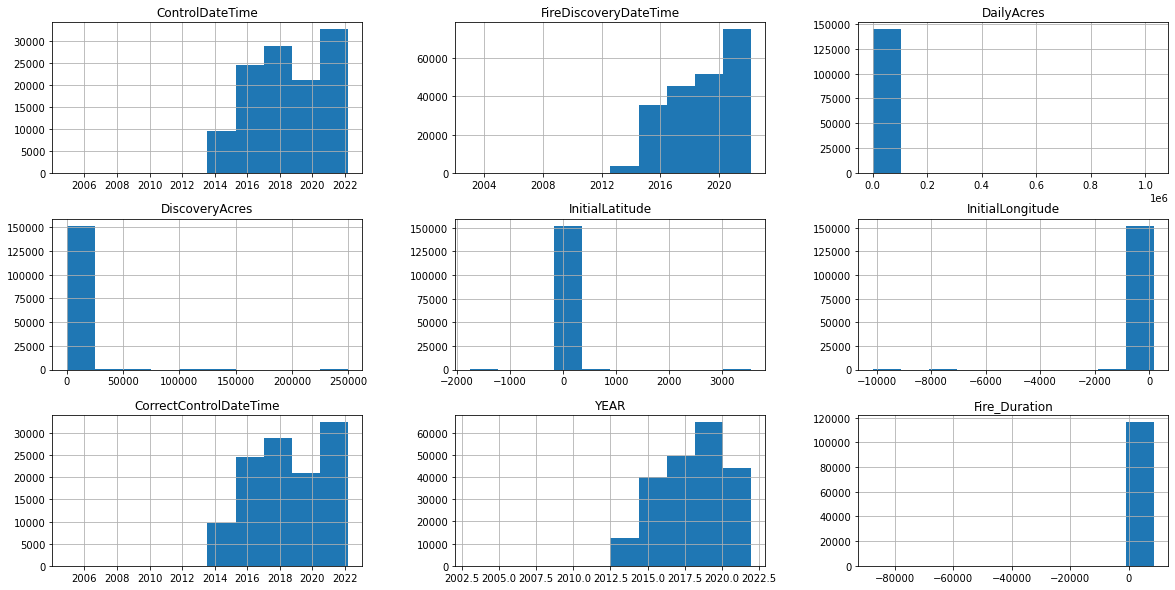

In [8]:
# Histogram for all features

fires_original.hist(figsize=[20,10])

In [9]:
fires_original.FireCauseGeneral.unique()

array(['Equipment', nan, 'Incendiary', 'Lightning', 'Debris/Open Burning',
       'Camping', 'Investigated but Undetermined', 'Other Human Cause',
       'Misc/Other', 'Cause and Origin Not Identified',
       'Firearms/Weapons', 'Other Natural Cause', 'Natural', 'Utilities',
       'Smoking', 'Debris Burning (Fire Use)', 'Coal Seam', 'Railroad',
       'Undetermined'], dtype=object)

In [10]:
# General Fire Cause to numerica values
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Incendiary','Other Human Cause','Debris/Open Burning','Equipment','Camping','Utilities','Firearms/Weapons','Investigated but Undetermined',
                                                                                 'Cause and Origin Not Identified','Coal Seam','Railroad','Smoking','Debris Burning (Fire Use)'],'1')
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Lightning','Other Natural Cause', 'Natural'],'2')
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Undetermined','Misc/Other', 'nan'],'3')

# Legend For General Cause
# 1 = Human
# 2 = Nature
# 3 = Uncategorized


In [11]:
# Import LE to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder

# Converting Fuel Model to Numeric and using Label encoders for this 
label_encoder = LabelEncoder()
fires_original["fueltype_num"] = label_encoder.fit_transform(fires_original["PredominantFuelModel"])

In [12]:
# fillna with mean/min values or dropna values; fillna datetime from another column

fires_original['ControlDateTime'].fillna(fires_original['ContainmentDateTime'], inplace=True)
#fires['ControlDateTime'].fillna(fires['FireDiscoveryDateTime'], inplace=True)
fires_da_mean = pd.DataFrame(fires_original).fillna(fires_original['DiscoveryAcres'].mean())
fires_da_median = pd.DataFrame(fires_original).fillna({'DiscoveryAcres': 0.1})
fires_da_drop = pd.DataFrame(fires_original).dropna(subset = ['DiscoveryAcres'])
#fires['DailyAcres'].fillna(0.1, inplace=True)
#fires_original.isnull().sum()

# Discovery Acres Section

Fire Severity base on Discovery Acres (fill na with mean value)

In [13]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (fillna with mean value)
fires_da_mean.loc[fires_da_mean['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > .25) & (fires_da_mean['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 10) & (fires_da_mean['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 100) & (fires_da_mean['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 300) & (fires_da_mean['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 1000) & (fires_da_mean['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_mean.loc[fires_da_mean['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_mean['fire_severity'].value_counts())

1.0    97131
3.0    66427
2.0    45336
4.0     1282
5.0      926
6.0      381
7.0       54
Name: fire_severity, dtype: int64


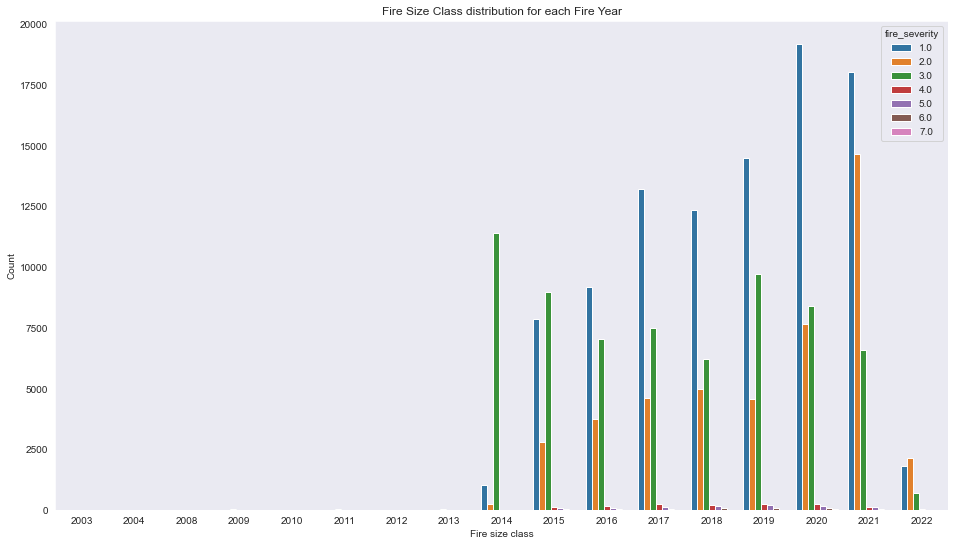

In [14]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_da_mean) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [15]:
fires_binary_encoded_mean = pd.get_dummies(fires_da_mean, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_mean = fires_binary_encoded_mean.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_mean.head()

,fire_severity,PredominantFuelModel_21.396284975138215,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,...,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_21.396284975138215,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


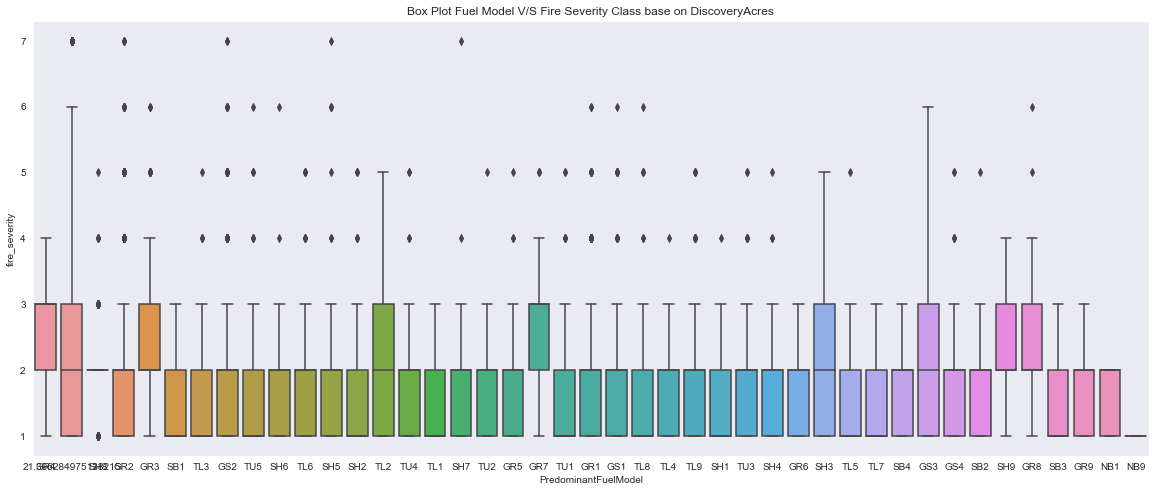

In [16]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_da_mean)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DiscoveryAcres')
plt.show()

In [17]:
# Define the features set.
X_mean = fires_binary_encoded_mean
X_mean = X_mean.drop(["fire_severity"], axis=1)
X_mean.head()

,PredominantFuelModel_21.396284975138215,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_21.396284975138215,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
# Define the target set.
y_mean = fires_binary_encoded_mean["fire_severity"].ravel()
y_mean[:5]

array([3., 1., 3., 3., 3.])

In [19]:
# Splitting into Train and Test sets.
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean, y_mean, random_state=78)

In [20]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_mean_scaler = scaler.fit(X_mean_train)

# Scaling the data.
X_mean_train_scaled = X_mean_scaler.transform(X_mean_train)
X_mean_test_scaled = X_mean_scaler.transform(X_mean_test)

In [21]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [22]:
# Fitting the model
rf_mean_model = rf_model.fit(X_mean_train_scaled, y_mean_train)

In [23]:
predictions_mean = rf_mean_model.predict(X_mean_test_scaled)

In [24]:
# Calculate feature importance in the Random Forest model.
importances_mean = rf_mean_model.feature_importances_
importances_mean

array([3.49818574e-01, 1.35768289e-02, 2.02962094e-02, 1.92809004e-02,
       3.20613453e-02, 1.93145551e-03, 1.97250704e-03, 3.56431542e-03,
       1.28677559e-03, 8.18283130e-04, 1.09852644e-02, 3.34825402e-02,
       3.97271819e-03, 1.32395516e-03, 1.81191642e-04, 0.00000000e+00,
       8.56590509e-03, 1.20121042e-03, 8.33221516e-04, 6.95140674e-04,
       2.38635803e-03, 3.47590189e-03, 2.57175330e-03, 2.44193587e-03,
       3.57619509e-03, 8.61154836e-04, 2.63682179e-03, 2.14223380e-03,
       2.19800420e-03, 7.52744743e-03, 9.16531474e-03, 6.99324932e-03,
       1.64761116e-03, 2.26452611e-03, 6.74196973e-03, 1.27264826e-03,
       1.18787376e-02, 5.86973323e-03, 1.54510141e-02, 4.05112895e-03,
       1.82213334e-03, 3.27342723e-03, 1.73725185e-02, 1.75522166e-01,
       1.31899116e-01, 4.59669275e-02, 2.31416305e-02])

In [25]:
# Features Sorted by Importance
sorted(zip(rf_mean_model.feature_importances_, X_mean.columns), reverse=True)

[(0.3498185741214428, 'PredominantFuelModel_21.396284975138215'),
 (0.1755221657405652, 'FireCauseGeneral_21.396284975138215'),
 (0.1318991156013867, 'FireCauseGeneral_1'),
 (0.04596692750777694, 'FireCauseGeneral_2'),
 (0.03348254018201409, 'PredominantFuelModel_GS2'),
 (0.032061345343050475, 'PredominantFuelModel_GR4'),
 (0.023141630524666224, 'FireCauseGeneral_3'),
 (0.02029620939689495, 'PredominantFuelModel_GR2'),
 (0.019280900412556878, 'PredominantFuelModel_GR3'),
 (0.017372518465387583, 'PredominantFuelModel_TU5'),
 (0.015451014080207014, 'PredominantFuelModel_TU1'),
 (0.0135768288965406, 'PredominantFuelModel_GR1'),
 (0.011878737648887494, 'PredominantFuelModel_TL8'),
 (0.010985264389473464, 'PredominantFuelModel_GS1'),
 (0.009165314739054421, 'PredominantFuelModel_TL2'),
 (0.00856590509342495, 'PredominantFuelModel_SB1'),
 (0.007527447428754195, 'PredominantFuelModel_TL1'),
 (0.006993249323547827, 'PredominantFuelModel_TL3'),
 (0.006741969729195454, 'PredominantFuelModel_TL6'

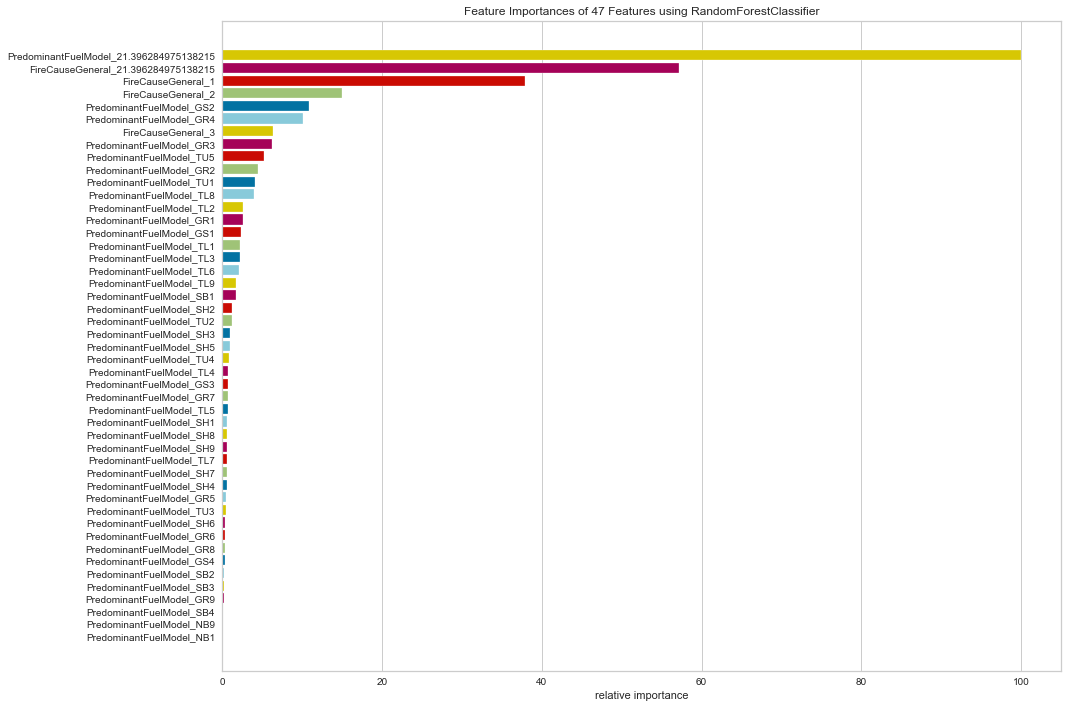

<AxesSubplot:title={'center':'Feature Importances of 47 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [26]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_mean = FeatureImportances(model, size=(1080, 720))

viz_mean.fit(X_mean, y_mean)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_mean.show()

In [27]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_mean = confusion_matrix(y_mean_test, predictions_mean)
# DataFrame from the confusion matrix.
cm_df_mean = pd.DataFrame(cm_mean, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_mean

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22095,1233,1075,0,1,0,0
Class 2,8437,1506,1203,1,1,0,0
Class 3,13440,494,2728,0,0,0,0
Class 4,250,26,53,0,0,0,0
Class 5,188,19,36,0,0,0,0
Class 6,78,2,7,0,0,0,0
Class 7,9,1,2,0,0,0,0


In [28]:
# Calculating the accuracy score.
acc_score_mean = accuracy_score(y_mean_test, predictions_mean)

In [29]:
# Displaying results
print("Confusion Matrix fillna with mean")
display(cm_df_mean)
print(f"Accuracy Score with mean: {acc_score_mean}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, predictions_mean))

Confusion Matrix fillna with mean


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22095,1233,1075,0,1,0,0
Class 2,8437,1506,1203,1,1,0,0
Class 3,13440,494,2728,0,0,0,0
Class 4,250,26,53,0,0,0,0
Class 5,188,19,36,0,0,0,0
Class 6,78,2,7,0,0,0,0
Class 7,9,1,2,0,0,0,0


Accuracy Score with mean: 0.4978538337902997
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64     24404
         2.0       0.46      0.14      0.21     11148
         3.0       0.53      0.16      0.25     16662
         4.0       0.00      0.00      0.00       329
         5.0       0.00      0.00      0.00       243
         6.0       0.00      0.00      0.00        87
         7.0       0.00      0.00      0.00        12

    accuracy                           0.50     52885
   macro avg       0.21      0.17      0.16     52885
weighted avg       0.49      0.50      0.42     52885



In [30]:
from imblearn.combine import SMOTEENN

fires_smoteen_mean = fires_da_mean.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_mean.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.000000,2020,3,3.0
1,0.100000,2020,42,1.0
2,50.000000,2017,42,3.0
3,21.396285,2019,42,3.0
4,21.396285,2016,42,3.0


In [31]:
x_mean_cols = [i for i in fires_smoteen_mean.columns if i not in ('fire_severity')]
X_mean = fires_smoteen_mean[x_mean_cols]
y_mean = fires_smoteen_mean['fire_severity']

In [32]:
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean, y_mean, random_state=1, stratify=y_mean)

In [33]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_mean_scaler = scaler.fit(X_mean_train)

# Scaling the data.
X_mean_train_scaled = X_mean_scaler.transform(X_mean_train)
X_mean_test_scaled = X_mean_scaler.transform(X_mean_test)

In [34]:
smoteenn = SMOTEENN(random_state=1)
X_mean_resampled, y_mean_resampled = smoteenn.fit_resample(X_mean_train_scaled, y_mean_train)
y_mean_resampled.value_counts()

5.0    72848
6.0    72848
7.0    72848
4.0    72845
1.0    72751
2.0    72717
3.0    72678
Name: fire_severity, dtype: int64

In [35]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_mean_resampled, y_mean_resampled)
smoteen_model.score(X_mean_resampled, y_mean_resampled)

0.8795490005593335

In [36]:
from sklearn.metrics import confusion_matrix

y_mean_pred = smoteen_model.predict(X_mean_test_scaled)
confusion_matrix(y_mean_test, y_mean_pred)

array([[17308,  6975,     0,     0,     0,     0,     0],
       [ 5613,  5451,   270,     0,     0,     0,     0],
       [    0,    56, 16366,   185,     0,     0,     0],
       [    0,     0,     0,   321,     0,     0,     0],
       [    0,     0,     0,     8,   224,     0,     0],
       [    0,     0,     0,     0,     6,    87,     2],
       [    0,     0,     0,     0,     0,     0,    13]])

In [37]:
from sklearn.metrics import balanced_accuracy_score

y_mean_pred = smoteen_model.predict(X_mean_test_scaled)
balanced_accuracy_score(y_mean_test, y_mean_pred)

0.8657855820517915

In [38]:
# Display the confusion matrix
smoteen_cm_mean = confusion_matrix(y_mean_test, y_mean_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_mean = pd.DataFrame(cm_mean, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                  columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_mean

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22095,1233,1075,0,1,0,0
Class 2,8437,1506,1203,1,1,0,0
Class 3,13440,494,2728,0,0,0,0
Class 4,250,26,53,0,0,0,0
Class 5,188,19,36,0,0,0,0
Class 6,78,2,7,0,0,0,0
Class 7,9,1,2,0,0,0,0


In [39]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced fillna with mean")
print(classification_report_imbalanced(y_mean_test, y_mean_pred))

Classification Report Imbalanced fillna with mean
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.76      0.71      0.80      0.73      0.76      0.57     24283
        2.0       0.44      0.48      0.83      0.46      0.63      0.39     11334
        3.0       0.98      0.99      0.99      0.98      0.99      0.98     16607
        4.0       0.62      1.00      1.00      0.77      1.00      1.00       321
        5.0       0.97      0.97      1.00      0.97      0.98      0.96       232
        6.0       1.00      0.92      1.00      0.96      0.96      0.91        95
        7.0       0.87      1.00      1.00      0.93      1.00      1.00        13

avg / total       0.76      0.75      0.87      0.75      0.81      0.66     52885



Fire Severity base on Discovery Acres (fill na with median value)

In [40]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (fillna with min value)
fires_da_median.loc[fires_da_median['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > .25) & (fires_da_median['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 10) & (fires_da_median['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 100) & (fires_da_median['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 300) & (fires_da_median['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 1000) & (fires_da_median['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_median.loc[fires_da_median['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_median['fire_severity'].value_counts())

1.0    157013
2.0     45336
3.0      6545
4.0      1282
5.0       926
6.0       381
7.0        54
Name: fire_severity, dtype: int64


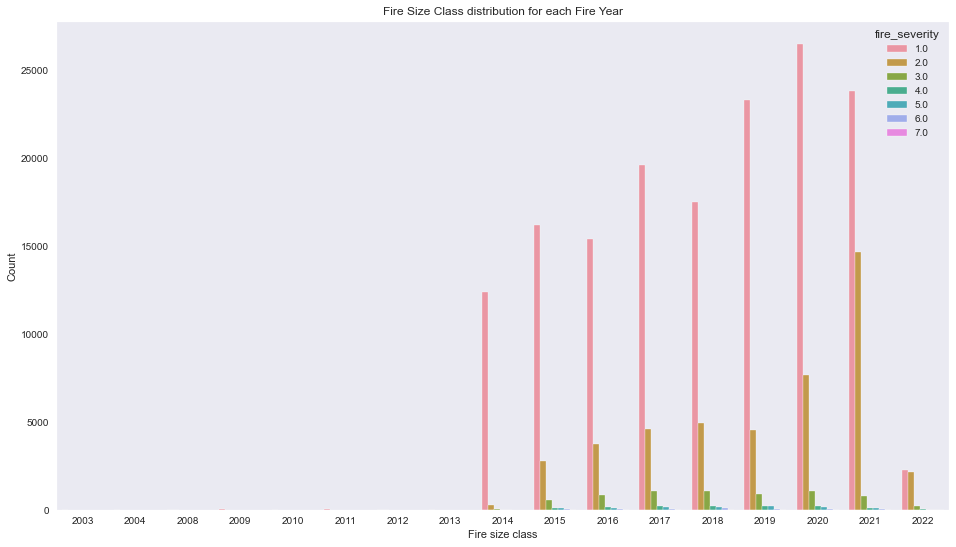

In [41]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_da_median) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [42]:
fires_binary_encoded_median = pd.get_dummies(fires_da_median, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_median = fires_binary_encoded_median.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_median.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


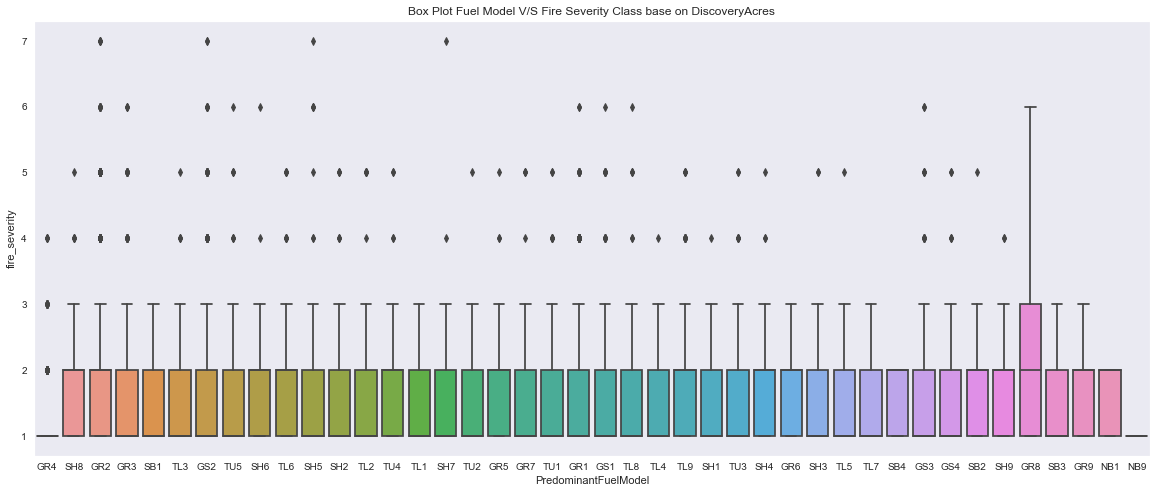

In [43]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_da_median)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DiscoveryAcres')
plt.show()

In [44]:
# Define the features set.
X_median = fires_binary_encoded_median
X_median = X_median.drop(["fire_severity"], axis=1)
X_median.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Define the target set.
y_median = fires_binary_encoded_median["fire_severity"].ravel()
y_median[:5]

array([3., 1., 3., 1., 1.])

In [46]:
# Splitting into Train and Test sets.
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y_median, random_state=78)

In [47]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_median_scaler = scaler.fit(X_median_train)

# Scaling the data.
X_median_train_scaled = X_median_scaler.transform(X_median_train)
X_median_test_scaled = X_median_scaler.transform(X_median_test)

In [48]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [49]:
# Fitting the model
rf_model_median = rf_model.fit(X_median_train_scaled, y_median_train)

In [50]:
predictions_median = rf_model_median.predict(X_median_test_scaled)

In [51]:
# Calculate feature importance in the Random Forest model.
importances_median = rf_model_median.feature_importances_
importances_median

array([0.03156692, 0.08979716, 0.01209927, 0.00797808, 0.00662381,
       0.00717465, 0.00208167, 0.00226626, 0.00174966, 0.02191648,
       0.07160264, 0.00576736, 0.0014785 , 0.00049227, 0.        ,
       0.00214093, 0.00440215, 0.00103429, 0.00189896, 0.00324606,
       0.00727018, 0.00145672, 0.00945064, 0.0118304 , 0.00299791,
       0.0086726 , 0.00901718, 0.00313492, 0.00476532, 0.00807187,
       0.00909824, 0.00545045, 0.00285992, 0.02938645, 0.00247961,
       0.0149667 , 0.03127456, 0.01834049, 0.01146116, 0.00681647,
       0.01261398, 0.02601308, 0.24313153, 0.17263582, 0.07148667])

In [52]:
# Features Sorted by Importance
sorted(zip(rf_model_median.feature_importances_, X_median.columns), reverse=True)

[(0.24313153404690926, 'FireCauseGeneral_1'),
 (0.17263581747109083, 'FireCauseGeneral_2'),
 (0.08979716054087318, 'PredominantFuelModel_GR2'),
 (0.07160263838787688, 'PredominantFuelModel_GS2'),
 (0.07148666856557785, 'FireCauseGeneral_3'),
 (0.031566922163692994, 'PredominantFuelModel_GR1'),
 (0.03127455886003708, 'PredominantFuelModel_TL9'),
 (0.02938644719578042, 'PredominantFuelModel_TL6'),
 (0.02601307840138963, 'PredominantFuelModel_TU5'),
 (0.021916479672701068, 'PredominantFuelModel_GS1'),
 (0.018340491578623958, 'PredominantFuelModel_TU1'),
 (0.014966700955744958, 'PredominantFuelModel_TL8'),
 (0.012613984973841192, 'PredominantFuelModel_TU4'),
 (0.012099273970769639, 'PredominantFuelModel_GR3'),
 (0.011830395825339948, 'PredominantFuelModel_SH5'),
 (0.011461159882717965, 'PredominantFuelModel_TU2'),
 (0.009450638210318878, 'PredominantFuelModel_SH4'),
 (0.009098242965652023, 'PredominantFuelModel_TL3'),
 (0.009017176809367219, 'PredominantFuelModel_SH8'),
 (0.008672603190394

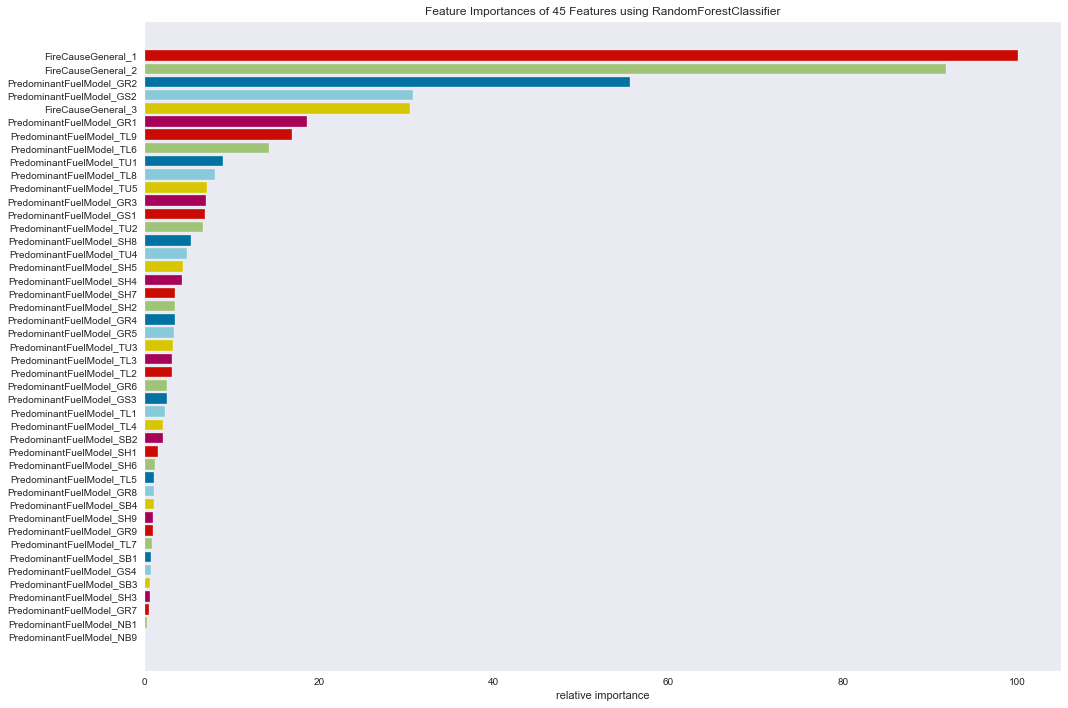

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [53]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_median = FeatureImportances(model, size=(1080, 720))

viz_median.fit(X_median, y_median)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_median.show()

In [54]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_median = confusion_matrix(y_median_test, predictions_median)
# DataFrame from the confusion matrix.
cm_df_median = pd.DataFrame(cm_median, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                         columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_median

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,38946,481,3,0,1,0,0
Class 2,10559,585,2,1,1,0,0
Class 3,1544,87,4,0,0,0,0
Class 4,316,13,0,0,0,0,0
Class 5,235,5,3,0,0,0,0
Class 6,85,2,0,0,0,0,0
Class 7,12,0,0,0,0,0,0


In [55]:
# Calculating the accuracy score.
acc_score_median = accuracy_score(y_median_test, predictions_median)

In [56]:
# Displaying results
print("Confusion Matrix fillna with median")
display(cm_df_median)
print(f"Accuracy Score with min : {acc_score_median}")
print("Classification Report fillna with median")
print(classification_report(y_median_test, predictions_median))

Confusion Matrix fillna with median


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,38946,481,3,0,1,0,0
Class 2,10559,585,2,1,1,0,0
Class 3,1544,87,4,0,0,0,0
Class 4,316,13,0,0,0,0,0
Class 5,235,5,3,0,0,0,0
Class 6,85,2,0,0,0,0,0
Class 7,12,0,0,0,0,0,0


Accuracy Score with min : 0.7475654722511109
Classification Report fillna with median
              precision    recall  f1-score   support

         1.0       0.75      0.99      0.85     39431
         2.0       0.50      0.05      0.09     11148
         3.0       0.33      0.00      0.00      1635
         4.0       0.00      0.00      0.00       329
         5.0       0.00      0.00      0.00       243
         6.0       0.00      0.00      0.00        87
         7.0       0.00      0.00      0.00        12

    accuracy                           0.75     52885
   macro avg       0.23      0.15      0.14     52885
weighted avg       0.68      0.75      0.66     52885



In [57]:
from imblearn.combine import SMOTEENN

fires_smoteen_median = fires_da_median.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','DailyAcres','FireDiscoveryDateTime','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_median.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.0,2020,3,3.0
1,0.1,2020,42,1.0
2,50.0,2017,42,3.0
3,0.1,2019,42,1.0
4,0.1,2016,42,1.0


In [58]:
x_median_cols = [i for i in fires_smoteen_median.columns if i not in ('fire_severity')]
X_median = fires_smoteen_median[x_median_cols]
y_median = fires_smoteen_median['fire_severity']

In [59]:
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y_median, random_state=1, stratify=y_median)

In [60]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_median_scaler = scaler.fit(X_median_train)

# Scaling the data.
X_median_train_scaled = X_median_scaler.transform(X_median_train)
X_median_test_scaled = X_median_scaler.transform(X_median_test)

In [61]:
smoteenn = SMOTEENN(random_state=1)
X_median_resampled, y_median_resampled = smoteenn.fit_resample(X_median_train_scaled, y_median_train)
y_median_resampled.value_counts()

5.0    117759
6.0    117759
7.0    117759
4.0    117757
3.0    117714
2.0    117645
1.0    117644
Name: fire_severity, dtype: int64

In [62]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_median_resampled, y_median_resampled)
smoteen_model.score(X_median_resampled, y_median_resampled)

0.8817152627855303

In [63]:
from sklearn.metrics import confusion_matrix

y_median_pred = smoteen_model.predict(X_median_test_scaled)
confusion_matrix(y_median_test, y_median_pred)

array([[26204, 13050,     0,     0,     0,     0,     0],
       [ 4906,  6428,     0,     0,     0,     0,     0],
       [    3,    35,  1594,     4,     0,     0,     0],
       [    0,     0,     6,   315,     0,     0,     0],
       [    0,     0,     0,     8,   224,     0,     0],
       [    0,     0,     0,     0,     2,    91,     2],
       [    0,     0,     0,     0,     0,     1,    12]])

In [64]:
from sklearn.metrics import balanced_accuracy_score

y_median_pred = smoteen_model.predict(X_median_test_scaled)
balanced_accuracy_score(y_median_test, y_median_pred)

0.8624025505636667

In [65]:
# Display the confusion matrix
smoteen_cm_median = confusion_matrix(y_median_test, y_median_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_median = pd.DataFrame(cm_median, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                 columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_median

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,38946,481,3,0,1,0,0
Class 2,10559,585,2,1,1,0,0
Class 3,1544,87,4,0,0,0,0
Class 4,316,13,0,0,0,0,0
Class 5,235,5,3,0,0,0,0
Class 6,85,2,0,0,0,0,0
Class 7,12,0,0,0,0,0,0


In [66]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced fillna with median")
print(classification_report_imbalanced(y_median_test, y_median_pred))

Classification Report Imbalanced fillna with median
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.84      0.67      0.64      0.74      0.65      0.43     39254
        2.0       0.33      0.57      0.69      0.42      0.62      0.38     11334
        3.0       1.00      0.97      1.00      0.99      0.99      0.97      1636
        4.0       0.96      0.98      1.00      0.97      0.99      0.98       321
        5.0       0.99      0.97      1.00      0.98      0.98      0.96       232
        6.0       0.99      0.96      1.00      0.97      0.98      0.95        95
        7.0       0.86      0.92      1.00      0.89      0.96      0.92        13

avg / total       0.74      0.66      0.67      0.68      0.66      0.44     52885



Fire Severity base on Discovery Acres (dropna value)

In [67]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (drop nan value)
fires_da_drop.loc[fires_da_drop['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > .25) & (fires_da_drop['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 10) & (fires_da_drop['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 100) & (fires_da_drop['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 300) & (fires_da_drop['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 1000) & (fires_da_drop['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_drop.loc[fires_da_drop['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_drop['fire_severity'].value_counts())

1.0    97131
2.0    45336
3.0     6545
4.0     1282
5.0      926
6.0      381
7.0       54
Name: fire_severity, dtype: int64


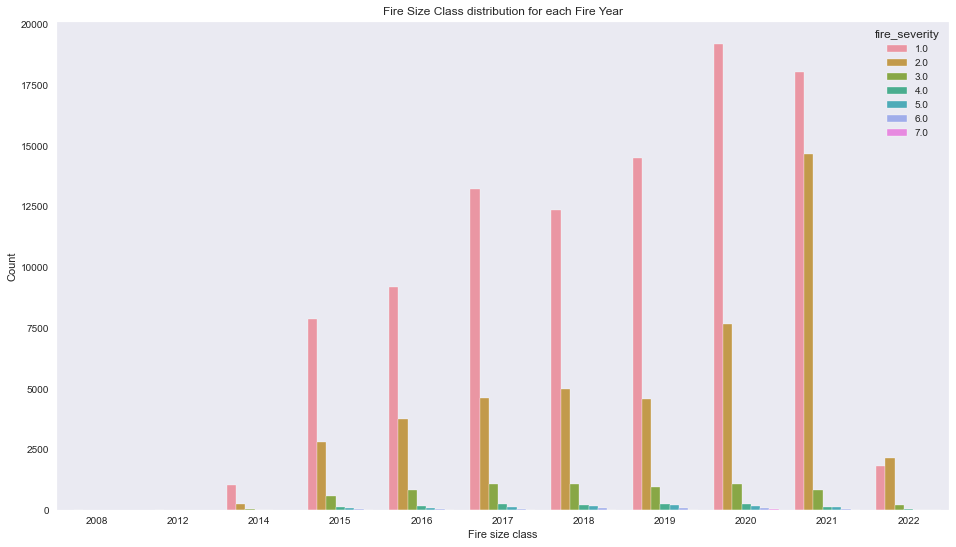

In [68]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_da_drop) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [69]:
fires_binary_encoded_drop = pd.get_dummies(fires_da_drop, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_drop = fires_binary_encoded_drop.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_drop.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


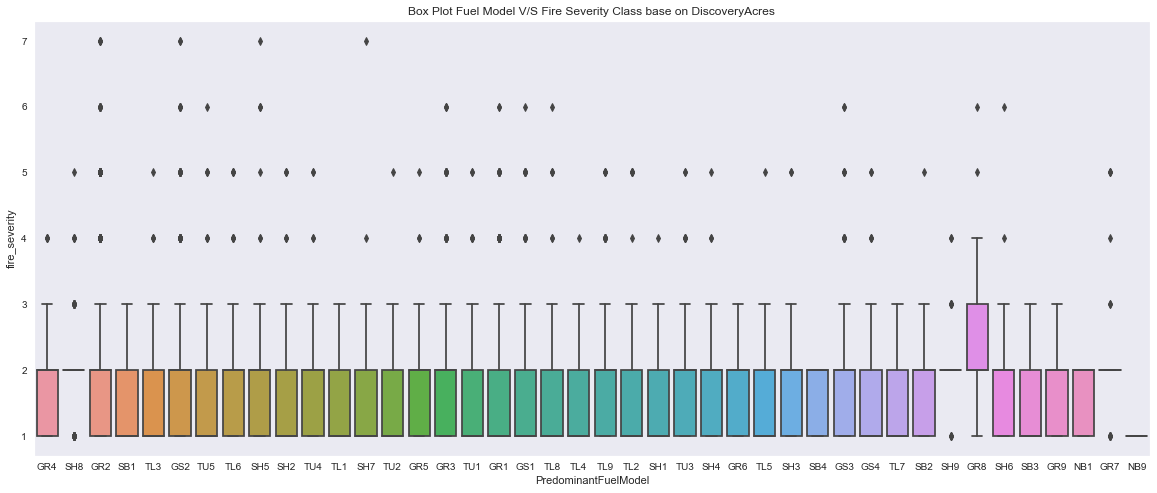

In [70]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_da_drop)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DiscoveryAcres')
plt.show()

In [71]:
# Define the features set.
X_drop = fires_binary_encoded_drop
X_drop = X_drop.drop(["fire_severity"], axis=1)
X_drop.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Define the target set.
y_drop = fires_binary_encoded_drop["fire_severity"].ravel()
y_drop[:5]

array([3., 1., 3., 2., 1.])

In [73]:
# Splitting into Train and Test sets.
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, random_state=78)

In [74]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_drop_scaler = scaler.fit(X_drop_train)

# Scaling the data.
X_drop_train_scaled = X_drop_scaler.transform(X_drop_train)
X_drop_test_scaled = X_drop_scaler.transform(X_drop_test)

In [75]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [76]:
# Fitting the model
rf_model_drop = rf_model.fit(X_drop_train_scaled, y_drop_train)

In [77]:
predictions_drop = rf_model_drop.predict(X_drop_test_scaled)

In [78]:
# Calculate feature importance in the Random Forest model.
importances_drop = rf_model_drop.feature_importances_
importances_drop

array([0.02061616, 0.05284154, 0.0153682 , 0.00146449, 0.00360862,
       0.0048442 , 0.00202032, 0.00177292, 0.00164917, 0.00960727,
       0.02807484, 0.00420701, 0.00176297, 0.00057738, 0.        ,
       0.00823147, 0.00233229, 0.00223426, 0.00109914, 0.00440546,
       0.00494157, 0.00175131, 0.00425466, 0.00432072, 0.00261155,
       0.00356678, 0.00450471, 0.00265676, 0.01632372, 0.00699692,
       0.01277858, 0.00358811, 0.00523038, 0.02037588, 0.00220761,
       0.00993157, 0.01842477, 0.01642202, 0.00710767, 0.00255613,
       0.00583223, 0.01452935, 0.42038992, 0.14217999, 0.09979938])

In [79]:
# Features Sorted by Importance
sorted(zip(rf_model_drop.feature_importances_, X_drop.columns), reverse=True)

[(0.4203899202536011, 'FireCauseGeneral_1'),
 (0.14217998628340486, 'FireCauseGeneral_2'),
 (0.09979938374422172, 'FireCauseGeneral_3'),
 (0.052841539679421394, 'PredominantFuelModel_GR2'),
 (0.028074843097387513, 'PredominantFuelModel_GS2'),
 (0.020616158149097202, 'PredominantFuelModel_GR1'),
 (0.020375883110013676, 'PredominantFuelModel_TL6'),
 (0.01842476643619963, 'PredominantFuelModel_TL9'),
 (0.0164220187429829, 'PredominantFuelModel_TU1'),
 (0.01632372489373533, 'PredominantFuelModel_TL1'),
 (0.015368204157260876, 'PredominantFuelModel_GR3'),
 (0.0145293523140366, 'PredominantFuelModel_TU5'),
 (0.012778578746489834, 'PredominantFuelModel_TL3'),
 (0.009931567245256533, 'PredominantFuelModel_TL8'),
 (0.009607266318572144, 'PredominantFuelModel_GS1'),
 (0.008231471414019398, 'PredominantFuelModel_SB1'),
 (0.00710767030183962, 'PredominantFuelModel_TU2'),
 (0.006996922149661363, 'PredominantFuelModel_TL2'),
 (0.005832231257485962, 'PredominantFuelModel_TU4'),
 (0.005230383513863819

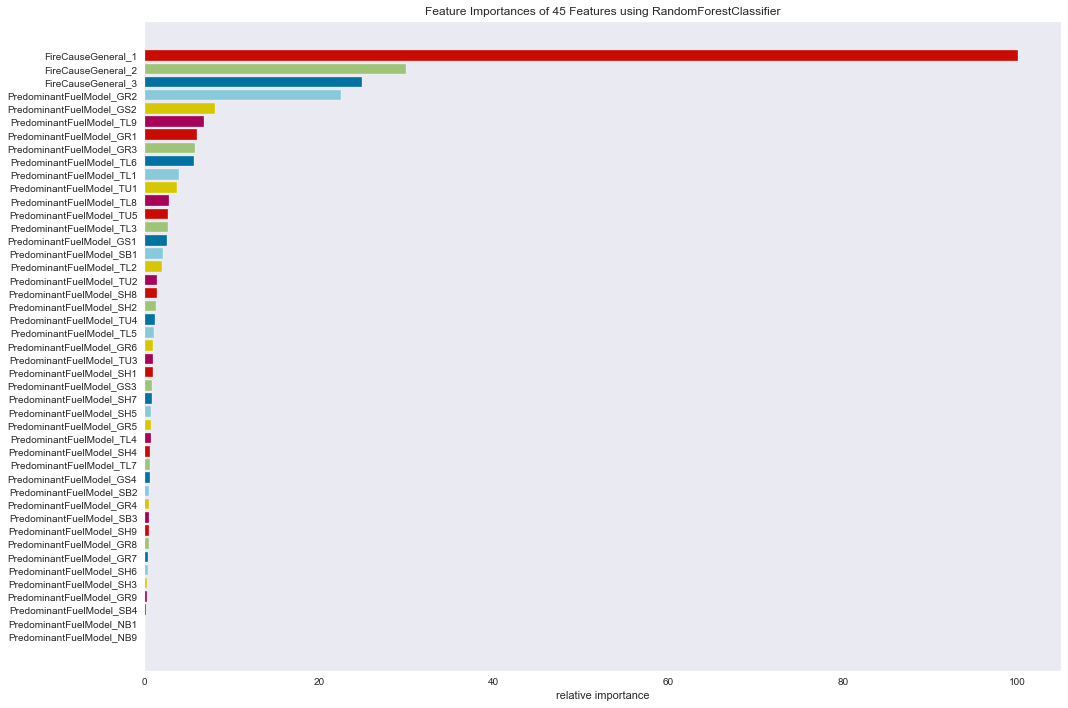

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [80]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_drop = FeatureImportances(model, size=(1080, 720))

viz_drop.fit(X_drop, y_drop)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_drop.show()

In [81]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_drop = confusion_matrix(y_drop_test, predictions_drop)
# DataFrame from the confusion matrix.
cm_df_drop = pd.DataFrame(cm_drop, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                          columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_drop

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22296,1851,3,0,1,0,0
Class 2,8998,2480,4,0,1,0,0
Class 3,1282,389,8,0,3,0,0
Class 4,220,56,0,0,0,0,0
Class 5,159,48,0,0,0,0,0
Class 6,83,13,0,0,0,0,0
Class 7,13,6,0,0,0,0,0


In [82]:
# Calculating the accuracy score.
acc_score_drop = accuracy_score(y_drop_test, predictions_drop)

In [83]:
# Displaying results
print("Confusion Matrix with dropna")
display(cm_df_drop)
print(f"Accuracy Score with dropna: {acc_score_drop}")
print("Classification Report with dropna")
print(classification_report(y_drop_test, predictions_drop))

Confusion Matrix with dropna


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22296,1851,3,0,1,0,0
Class 2,8998,2480,4,0,1,0,0
Class 3,1282,389,8,0,3,0,0
Class 4,220,56,0,0,0,0,0
Class 5,159,48,0,0,0,0,0
Class 6,83,13,0,0,0,0,0
Class 7,13,6,0,0,0,0,0


Accuracy Score with dropna: 0.6536899298412197
Classification Report with dropna
              precision    recall  f1-score   support

         1.0       0.67      0.92      0.78     24151
         2.0       0.51      0.22      0.30     11483
         3.0       0.53      0.00      0.01      1682
         4.0       0.00      0.00      0.00       276
         5.0       0.00      0.00      0.00       207
         6.0       0.00      0.00      0.00        96
         7.0       0.00      0.00      0.00        19

    accuracy                           0.65     37914
   macro avg       0.25      0.16      0.16     37914
weighted avg       0.61      0.65      0.59     37914



In [84]:
from imblearn.combine import SMOTEENN

fires_smoteen_drop = fires_da_drop.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_drop.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.0,2020,3,3.0
1,0.1,2020,42,1.0
2,50.0,2017,42,3.0
5,1.0,2020,26,2.0
6,0.1,2019,42,1.0


In [85]:
x_drop_cols = [i for i in fires_smoteen_drop.columns if i not in ('fire_severity')]
X_drop = fires_smoteen_drop[x_drop_cols]
y_drop = fires_smoteen_drop['fire_severity']

In [86]:
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, random_state=1, stratify=y_drop)

In [87]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_drop_scaler = scaler.fit(X_drop_train)

# Scaling the data.
X_drop_train_scaled = X_drop_scaler.transform(X_drop_train)
X_drop_test_scaled = X_drop_scaler.transform(X_drop_test)

In [88]:
smoteenn = SMOTEENN(random_state=1)
X_drop_resampled, y_drop_resampled = smoteenn.fit_resample(X_drop_train_scaled, y_drop_train)
y_drop_resampled.value_counts()

5.0    72848
6.0    72848
7.0    72848
4.0    72846
1.0    72776
3.0    72771
2.0    72706
Name: fire_severity, dtype: int64

In [89]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_drop_resampled, y_drop_resampled)
smoteen_model.score(X_drop_resampled, y_drop_resampled)

0.864104873411388

In [90]:
from sklearn.metrics import confusion_matrix

y_drop_pred = smoteen_model.predict(X_drop_test_scaled)
confusion_matrix(y_drop_test, y_drop_pred)

array([[17292,  6991,     0,     0,     0,     0,     0],
       [ 5945,  5345,    44,     0,     0,     0,     0],
       [   20,   131,  1472,    13,     0,     0,     0],
       [    0,     0,     9,   312,     0,     0,     0],
       [    0,     0,     0,     8,   224,     0,     0],
       [    0,     0,     0,     0,     1,    94,     0],
       [    0,     0,     0,     0,     0,     2,    11]])

In [91]:
from sklearn.metrics import balanced_accuracy_score

y_drop_pred = smoteen_model.predict(X_drop_test_scaled)
balanced_accuracy_score(y_drop_test, y_drop_pred)

0.8366508448102765

In [92]:
# Display the confusion matrix
smoteen_cm_drop = confusion_matrix(y_drop_test, y_drop_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_drop = pd.DataFrame(cm_drop, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                  columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_drop

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22296,1851,3,0,1,0,0
Class 2,8998,2480,4,0,1,0,0
Class 3,1282,389,8,0,3,0,0
Class 4,220,56,0,0,0,0,0
Class 5,159,48,0,0,0,0,0
Class 6,83,13,0,0,0,0,0
Class 7,13,6,0,0,0,0,0


In [93]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced with dropna")
print(classification_report_imbalanced(y_drop_test, y_drop_pred))

Classification Report Imbalanced with dropna
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.74      0.71      0.56      0.73      0.63      0.41     24283
        2.0       0.43      0.47      0.73      0.45      0.59      0.34     11334
        3.0       0.97      0.90      1.00      0.93      0.95      0.89      1636
        4.0       0.94      0.97      1.00      0.95      0.99      0.97       321
        5.0       1.00      0.97      1.00      0.98      0.98      0.96       232
        6.0       0.98      0.99      1.00      0.98      0.99      0.99        95
        7.0       1.00      0.85      1.00      0.92      0.92      0.83        13

avg / total       0.66      0.65      0.64      0.66      0.64      0.42     37914



# Daily Acres Section

In [94]:
# fillna with mean/min values or dropna values; fillna datetime from another column

fires_daily_mean = pd.DataFrame(fires_original).fillna(fires_original['DailyAcres'].mean())
fires_daily_min = pd.DataFrame(fires_original).fillna({'DailyAcres': 0.1})
fires_daily_drop = pd.DataFrame(fires_original).dropna(subset = ['DailyAcres'])

Fire Severity base on Daily Acres (fill na with mean value)

In [95]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires_daily_mean.loc[fires_daily_mean['DailyAcres'] <= .25, 'fire_severity'] = 1
fires_daily_mean.loc[(fires_daily_mean['DailyAcres'] > .25) & (fires_daily_mean['DailyAcres'] <= 10), 'fire_severity'] = 2
fires_daily_mean.loc[(fires_daily_mean['DailyAcres'] > 10) & (fires_daily_mean['DailyAcres'] <= 100), 'fire_severity'] = 3
fires_daily_mean.loc[(fires_daily_mean['DailyAcres'] > 100) & (fires_daily_mean['DailyAcres'] <= 300), 'fire_severity'] = 4
fires_daily_mean.loc[(fires_daily_mean['DailyAcres'] > 300) & (fires_daily_mean['DailyAcres'] <= 1000), 'fire_severity'] = 5
fires_daily_mean.loc[(fires_daily_mean['DailyAcres'] > 1000) & (fires_daily_mean['DailyAcres'] <= 5000), 'fire_severity'] = 6
fires_daily_mean.loc[fires_daily_mean['DailyAcres'] > 5000, 'fire_severity'] = 7          
print(fires_daily_mean['fire_severity'].value_counts())

5.0    72069
1.0    68015
2.0    46174
3.0    14145
4.0     5918
6.0     3492
7.0     1724
Name: fire_severity, dtype: int64


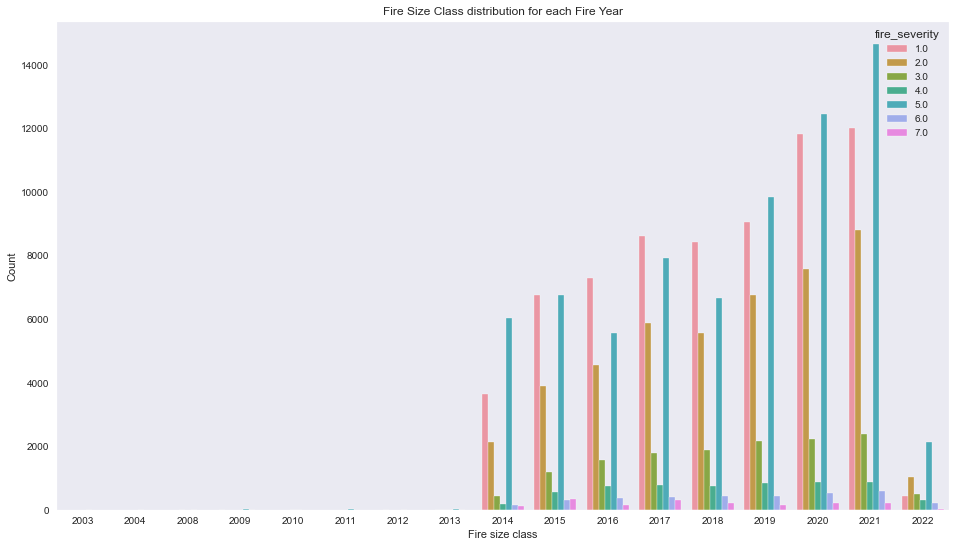

In [96]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_daily_mean) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [97]:
fires_binary_encoded_dmean = pd.get_dummies(fires_daily_mean, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_dmean = fires_binary_encoded_dmean.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_dmean.head()

,fire_severity,PredominantFuelModel_503.6945041885332,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,...,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_503.6945041885332,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,5.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


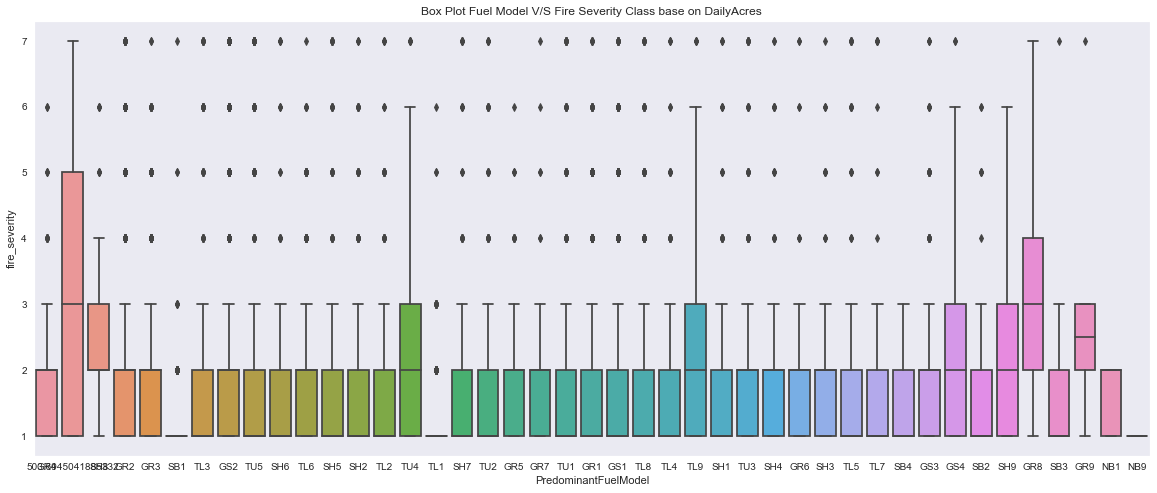

In [98]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_daily_mean)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DailyAcres')
plt.show()

In [99]:
# Define the features set.
X_dmean = fires_binary_encoded_dmean
X_dmean = X_dmean.drop(["fire_severity"], axis=1)
X_dmean.head()

,PredominantFuelModel_503.6945041885332,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_503.6945041885332,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [100]:
# Define the target set.
y_dmean = fires_binary_encoded_dmean["fire_severity"].ravel()
y_dmean[:5]

array([3., 5., 3., 5., 5.])

In [101]:
# Splitting into Train and Test sets.
X_dmean_train, X_dmean_test, y_dmean_train, y_dmean_test = train_test_split(X_dmean, y_dmean, random_state=78)

In [102]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_dmean_scaler = scaler.fit(X_dmean_train)

# Scaling the data.
X_dmean_train_scaled = X_dmean_scaler.transform(X_dmean_train)
X_dmean_test_scaled = X_dmean_scaler.transform(X_dmean_test)

In [103]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [104]:
# Fitting the model
rf_dmean_model = rf_model.fit(X_dmean_train_scaled, y_dmean_train)

In [105]:
predictions_dmean = rf_dmean_model.predict(X_dmean_test_scaled)

In [106]:
# Calculate feature importance in the Random Forest model.
importances_dmean = rf_dmean_model.feature_importances_
importances_dmean

array([3.98828658e-01, 3.06679090e-02, 2.41360966e-02, 4.27529052e-03,
       2.79294328e-03, 2.58220515e-03, 1.43049985e-03, 1.59262333e-03,
       1.27327748e-03, 6.65828164e-04, 7.51886720e-03, 2.01341508e-02,
       1.53558813e-03, 1.60900839e-03, 1.52998744e-04, 0.00000000e+00,
       1.71252253e-02, 1.97852300e-03, 6.76582474e-04, 3.24182287e-04,
       1.94756701e-03, 1.96094709e-03, 7.84107319e-04, 1.08636457e-03,
       4.16000516e-03, 6.86503002e-04, 1.89628646e-03, 2.19933336e-03,
       9.85806567e-04, 1.33819053e-02, 2.91056850e-03, 1.18394587e-02,
       1.50620359e-03, 4.07879171e-03, 4.53303082e-03, 1.25347718e-03,
       7.71507115e-03, 4.88198284e-03, 2.01853715e-02, 3.11195431e-03,
       1.32043672e-03, 3.31592273e-03, 1.03784765e-02, 1.90921488e-01,
       1.31172119e-01, 4.71912279e-02, 5.29513571e-03])

In [107]:
# Features Sorted by Importance
sorted(zip(rf_dmean_model.feature_importances_, X_dmean.columns), reverse=True)

[(0.39882865761368774, 'PredominantFuelModel_503.6945041885332'),
 (0.19092148839757075, 'FireCauseGeneral_503.6945041885332'),
 (0.1311721185131813, 'FireCauseGeneral_1'),
 (0.047191227921838184, 'FireCauseGeneral_2'),
 (0.030667908989186223, 'PredominantFuelModel_GR1'),
 (0.024136096642500323, 'PredominantFuelModel_GR2'),
 (0.020185371517626307, 'PredominantFuelModel_TU1'),
 (0.020134150848743638, 'PredominantFuelModel_GS2'),
 (0.017125225339823233, 'PredominantFuelModel_SB1'),
 (0.013381905274795249, 'PredominantFuelModel_TL1'),
 (0.011839458656634261, 'PredominantFuelModel_TL3'),
 (0.010378476524766502, 'PredominantFuelModel_TU5'),
 (0.007715071147896713, 'PredominantFuelModel_TL8'),
 (0.007518867200353907, 'PredominantFuelModel_GS1'),
 (0.005295135708193452, 'FireCauseGeneral_3'),
 (0.004881982837869086, 'PredominantFuelModel_TL9'),
 (0.004533030815079442, 'PredominantFuelModel_TL6'),
 (0.0042752905197341136, 'PredominantFuelModel_GR3'),
 (0.004160005156182147, 'PredominantFuelMod

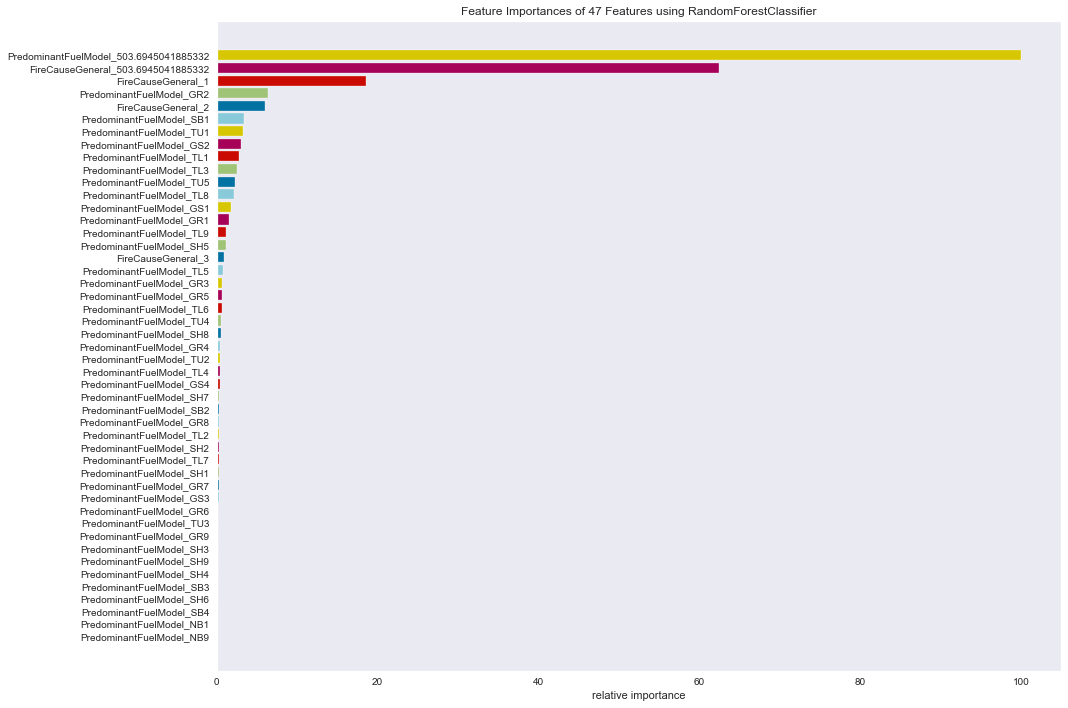

<AxesSubplot:title={'center':'Feature Importances of 47 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [108]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_dmean = FeatureImportances(model, size=(1080, 720))

viz_dmean.fit(X_dmean, y_dmean)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_dmean.show()

In [109]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_dmean = confusion_matrix(y_dmean_test, predictions_dmean)
# DataFrame from the confusion matrix.
cm_df_dmean = pd.DataFrame(cm_dmean, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_dmean

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,4412,219,5,1,12348,1,0
Class 2,2316,212,16,0,8887,0,0
Class 3,603,96,20,0,2871,1,0
Class 4,151,28,3,0,1292,0,0
Class 5,107,15,9,0,18008,0,0
Class 6,69,12,2,0,758,0,0
Class 7,52,2,1,0,368,0,0


In [110]:
# Calculating the accuracy score.
acc_score_dmean = accuracy_score(y_dmean_test, predictions_dmean)

In [111]:
# Displaying results
print("Confusion Matrix fillna with mean")
display(cm_df_dmean)
print(f"Accuracy Score with mean: {acc_score_dmean}")
print("Classification Report fillna with mean")
print(classification_report(y_dmean_test, predictions_dmean))

Confusion Matrix fillna with mean


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,4412,219,5,1,12348,1,0
Class 2,2316,212,16,0,8887,0,0
Class 3,603,96,20,0,2871,1,0
Class 4,151,28,3,0,1292,0,0
Class 5,107,15,9,0,18008,0,0
Class 6,69,12,2,0,758,0,0
Class 7,52,2,1,0,368,0,0


Accuracy Score with mean: 0.428325612177366
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.57      0.26      0.36     16986
         2.0       0.36      0.02      0.04     11431
         3.0       0.36      0.01      0.01      3591
         4.0       0.00      0.00      0.00      1474
         5.0       0.40      0.99      0.57     18139
         6.0       0.00      0.00      0.00       841
         7.0       0.00      0.00      0.00       423

    accuracy                           0.43     52885
   macro avg       0.24      0.18      0.14     52885
weighted avg       0.43      0.43      0.32     52885



In [112]:
from imblearn.combine import SMOTEENN

fires_smoteen_dmean = fires_daily_mean.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DiscoveryAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_dmean.head()

,DailyAcres,YEAR,fueltype_num,fire_severity
0,50.600000,2020,3,3.0
1,503.694504,2020,42,5.0
2,50.000000,2017,42,3.0
3,503.694504,2019,42,5.0
4,503.694504,2016,42,5.0


In [113]:
x_dmean_cols = [i for i in fires_smoteen_dmean.columns if i not in ('fire_severity')]
X_dmean = fires_smoteen_dmean[x_dmean_cols]
y_dmean = fires_smoteen_dmean['fire_severity']

In [114]:
X_dmean_train, X_dmean_test, y_dmean_train, y_dmean_test = train_test_split(X_dmean, y_dmean, random_state=1, stratify=y_dmean)

In [115]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_dmean_scaler = scaler.fit(X_dmean_train)

# Scaling the data.
X_dmean_train_scaled = X_dmean_scaler.transform(X_dmean_train)
X_dmean_test_scaled = X_dmean_scaler.transform(X_dmean_test)

In [116]:
smoteenn = SMOTEENN(random_state=1)
X_dmean_resampled, y_dmean_resampled = smoteenn.fit_resample(X_dmean_train_scaled, y_dmean_train)
y_dmean_resampled.value_counts()

7.0    54050
6.0    54046
1.0    53966
4.0    53963
5.0    53893
3.0    53880
2.0    53844
Name: fire_severity, dtype: int64

In [117]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_dmean_resampled, y_dmean_resampled)

LogisticRegression()

In [118]:
from sklearn.metrics import confusion_matrix

y_dmean_pred = smoteen_model.predict(X_dmean_test_scaled)
confusion_matrix(y_dmean_test, y_dmean_pred)

array([[ 8973,  7166,   865,     0,     0,     0,     0],
       [ 5715,  4577,  1252,     0,     0,     0,     0],
       [ 1397,   342,  1544,   253,     0,     0,     0],
       [   19,     0,     0,  1461,     0,     0,     0],
       [    0,     0,     0,   179, 17775,    63,     0],
       [    0,     0,     0,     0,     0,   868,     5],
       [    0,     0,     0,     0,     0,     9,   422]])

In [119]:
from sklearn.metrics import balanced_accuracy_score

y_dmean_pred = smoteen_model.predict(X_dmean_test_scaled)
balanced_accuracy_score(y_dmean_test, y_dmean_pred)

0.7582793322745002

In [120]:
# Display the confusion matrix
smoteen_cm_dmean = confusion_matrix(y_dmean_test, y_dmean_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_dmean = pd.DataFrame(cm_dmean, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                   columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_dmean

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,4412,219,5,1,12348,1,0
Class 2,2316,212,16,0,8887,0,0
Class 3,603,96,20,0,2871,1,0
Class 4,151,28,3,0,1292,0,0
Class 5,107,15,9,0,18008,0,0
Class 6,69,12,2,0,758,0,0
Class 7,52,2,1,0,368,0,0


In [121]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced fillna with mean")
print(classification_report_imbalanced(y_dmean_test, y_dmean_pred))

Classification Report Imbalanced fillna with mean
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.56      0.53      0.80      0.54      0.65      0.41     17004
        2.0       0.38      0.40      0.82      0.39      0.57      0.31     11544
        3.0       0.42      0.44      0.96      0.43      0.65      0.40      3536
        4.0       0.77      0.99      0.99      0.87      0.99      0.98      1480
        5.0       1.00      0.99      1.00      0.99      0.99      0.99     18017
        6.0       0.92      0.99      1.00      0.96      1.00      0.99       873
        7.0       0.99      0.98      1.00      0.98      0.99      0.98       431

avg / total       0.68      0.67      0.89      0.67      0.77      0.61     52885



Fire Severity base on Daily Acres (fill na with (0.1) value)

In [122]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires_daily_min.loc[fires_daily_min['DailyAcres'] <= .25, 'fire_severity'] = 1
fires_daily_min.loc[(fires_daily_min['DailyAcres'] > .25) & (fires_daily_min['DailyAcres'] <= 10), 'fire_severity'] = 2
fires_daily_min.loc[(fires_daily_min['DailyAcres'] > 10) & (fires_daily_min['DailyAcres'] <= 100), 'fire_severity'] = 3
fires_daily_min.loc[(fires_daily_min['DailyAcres'] > 100) & (fires_daily_min['DailyAcres'] <= 300), 'fire_severity'] = 4
fires_daily_min.loc[(fires_daily_min['DailyAcres'] > 300) & (fires_daily_min['DailyAcres'] <= 1000), 'fire_severity'] = 5
fires_daily_min.loc[(fires_daily_min['DailyAcres'] > 1000) & (fires_daily_min['DailyAcres'] <= 5000), 'fire_severity'] = 6
fires_daily_min.loc[fires_daily_min['DailyAcres'] > 5000, 'fire_severity'] = 7          
print(fires_daily_min['fire_severity'].value_counts())

1.0    135128
2.0     46174
3.0     14145
4.0      5918
5.0      4956
6.0      3492
7.0      1724
Name: fire_severity, dtype: int64


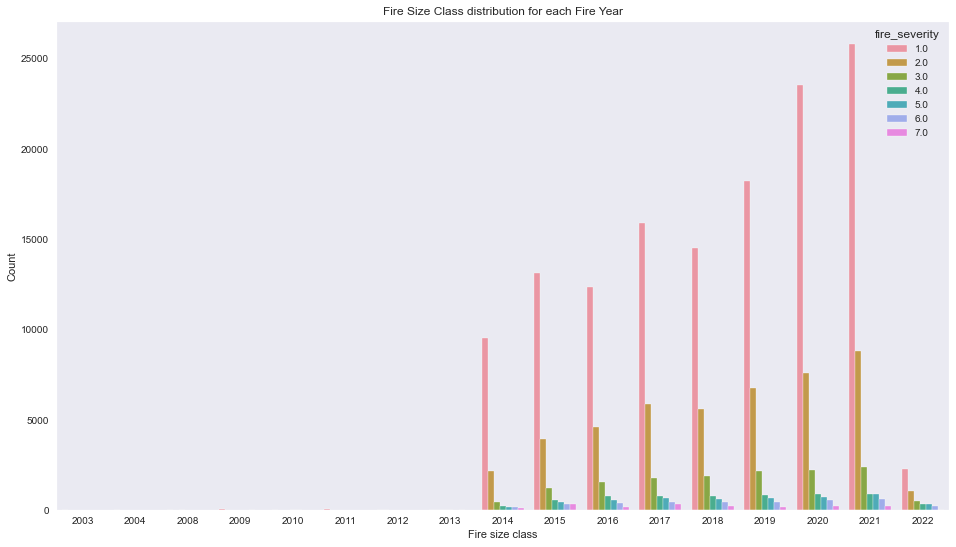

In [123]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_daily_min) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [124]:
fires_binary_encoded_dmin = pd.get_dummies(fires_daily_min, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_dmin = fires_binary_encoded_dmin.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_dmin.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


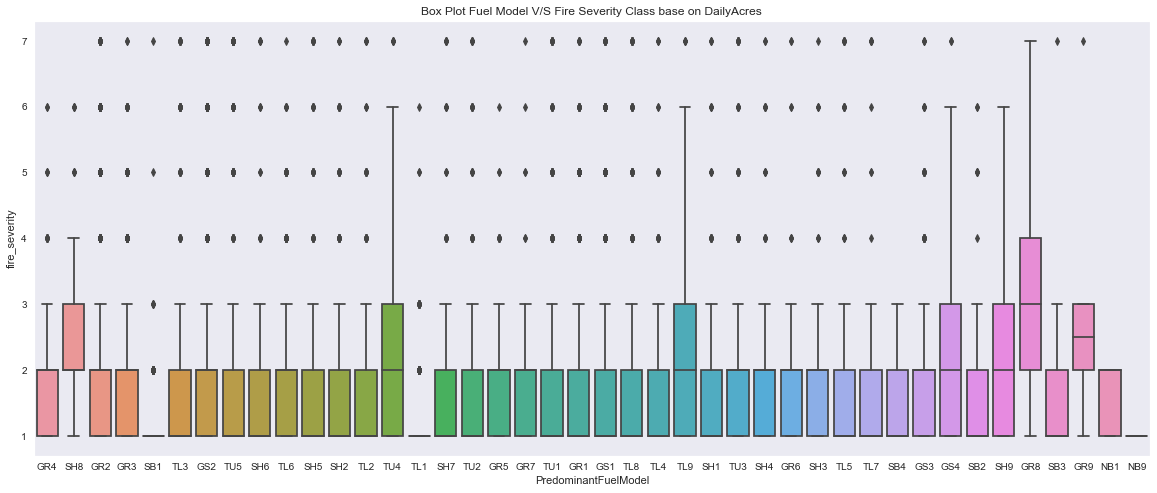

In [125]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_daily_min)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DailyAcres')
plt.show()

In [126]:
# Define the features set.
X_dmin = fires_binary_encoded_dmin
X_dmin = X_dmin.drop(["fire_severity"], axis=1)
X_dmin.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# Define the target set.
y_dmin = fires_binary_encoded_dmin["fire_severity"].ravel()
y_dmin[:5]

array([3., 1., 3., 1., 1.])

In [128]:
# Splitting into Train and Test sets.
X_dmin_train, X_dmin_test, y_dmin_train, y_dmin_test = train_test_split(X_dmin, y_dmin, random_state=78)

In [129]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_dmin_scaler = scaler.fit(X_dmin_train)

# Scaling the data.
X_dmin_train_scaled = X_dmin_scaler.transform(X_dmin_train)
X_dmin_test_scaled = X_dmin_scaler.transform(X_dmin_test)

In [130]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [131]:
# Fitting the model
rf_dmin_model = rf_model.fit(X_dmin_train_scaled, y_dmin_train)

In [132]:
predictions_dmin = rf_dmin_model.predict(X_dmin_test_scaled)

In [133]:
# Calculate feature importance in the Random Forest model.
importances_dmin = rf_dmin_model.feature_importances_
importances_dmin

array([0.02185679, 0.07435884, 0.03064518, 0.01619053, 0.01248095,
       0.00835573, 0.00744353, 0.00512926, 0.00298381, 0.01029594,
       0.06062426, 0.0092513 , 0.0066003 , 0.00068968, 0.        ,
       0.04114662, 0.00570379, 0.00219415, 0.0014569 , 0.00512385,
       0.00587203, 0.00334261, 0.00651388, 0.01545155, 0.00310802,
       0.00740047, 0.01041047, 0.0042959 , 0.02848756, 0.00857446,
       0.01713747, 0.00344174, 0.0106082 , 0.0275715 , 0.00459254,
       0.01427173, 0.02876921, 0.02771178, 0.00482591, 0.00595129,
       0.01734041, 0.01321848, 0.31834533, 0.06240014, 0.02782591])

In [134]:
# Features Sorted by Importance
sorted(zip(rf_dmin_model.feature_importances_, X_dmin.columns), reverse=True)

[(0.31834532767734336, 'FireCauseGeneral_1'),
 (0.07435884363000872, 'PredominantFuelModel_GR2'),
 (0.06240013734677278, 'FireCauseGeneral_2'),
 (0.06062426384959883, 'PredominantFuelModel_GS2'),
 (0.04114662052520368, 'PredominantFuelModel_SB1'),
 (0.030645184774280007, 'PredominantFuelModel_GR3'),
 (0.028769209033714747, 'PredominantFuelModel_TL9'),
 (0.028487562065096783, 'PredominantFuelModel_TL1'),
 (0.027825914446891507, 'FireCauseGeneral_3'),
 (0.02771178081012551, 'PredominantFuelModel_TU1'),
 (0.027571501225856634, 'PredominantFuelModel_TL6'),
 (0.021856785198265966, 'PredominantFuelModel_GR1'),
 (0.01734041115509848, 'PredominantFuelModel_TU4'),
 (0.01713746856097802, 'PredominantFuelModel_TL3'),
 (0.01619052650529245, 'PredominantFuelModel_GR4'),
 (0.015451553694659975, 'PredominantFuelModel_SH5'),
 (0.014271729242365075, 'PredominantFuelModel_TL8'),
 (0.01321847999849473, 'PredominantFuelModel_TU5'),
 (0.012480954944605072, 'PredominantFuelModel_GR5'),
 (0.0106082011406584,

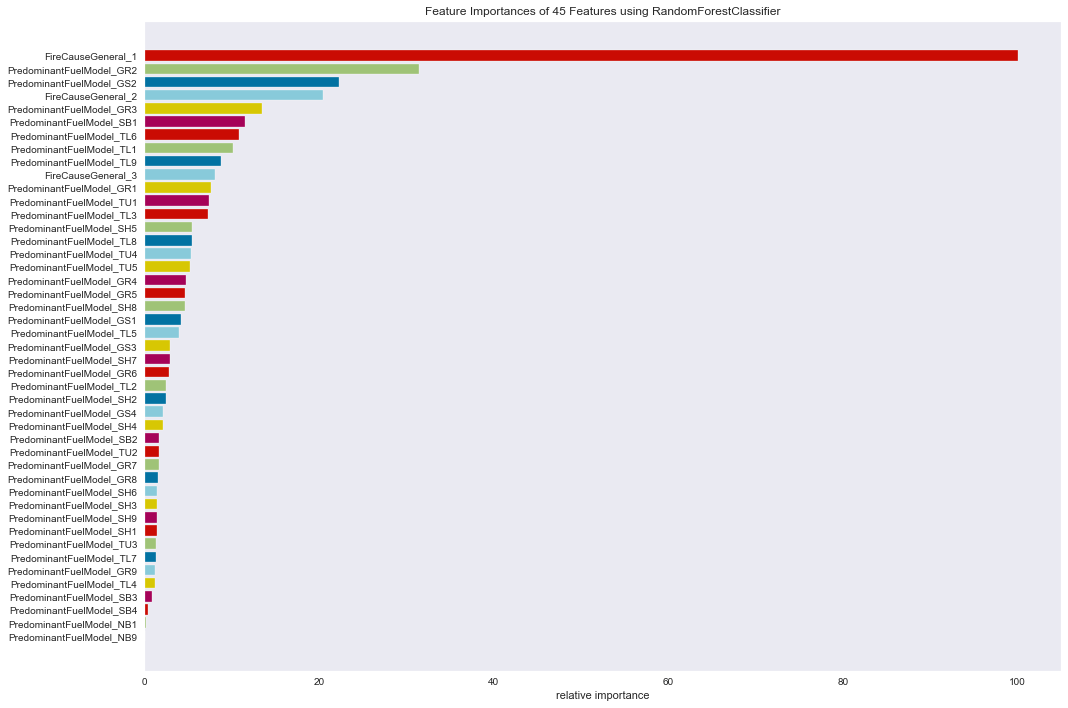

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [135]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_dmin = FeatureImportances(model, size=(1080, 720))

viz_dmin.fit(X_dmin, y_dmin)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_dmin.show()

In [136]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_dmin = confusion_matrix(y_dmin_test, predictions_dmin)
# DataFrame from the confusion matrix.
cm_df_dmin = pd.DataFrame(cm_dmin, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_dmin

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,33628,219,7,1,0,1,0
Class 2,11201,212,16,0,2,0,0
Class 3,3475,96,19,0,0,1,0
Class 4,1443,28,3,0,0,0,0
Class 5,1247,15,7,0,0,0,0
Class 6,826,12,2,0,1,0,0
Class 7,420,2,1,0,0,0,0


In [137]:
# Calculating the accuracy score.
acc_score_dmin = accuracy_score(y_dmin_test, predictions_dmin)

In [138]:
# Displaying results
print("Confusion Matrix fillna with min")
display(cm_df_dmin)
print(f"Accuracy Score with min: {acc_score_dmin}")
print("Classification Report fillna with min")
print(classification_report(y_dmin_test, predictions_dmin))

Confusion Matrix fillna with min


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,33628,219,7,1,0,1,0
Class 2,11201,212,16,0,2,0,0
Class 3,3475,96,19,0,0,1,0
Class 4,1443,28,3,0,0,0,0
Class 5,1247,15,7,0,0,0,0
Class 6,826,12,2,0,1,0,0
Class 7,420,2,1,0,0,0,0


Accuracy Score with min: 0.6402382528127069
Classification Report fillna with min
              precision    recall  f1-score   support

         1.0       0.64      0.99      0.78     33856
         2.0       0.36      0.02      0.04     11431
         3.0       0.35      0.01      0.01      3591
         4.0       0.00      0.00      0.00      1474
         5.0       0.00      0.00      0.00      1269
         6.0       0.00      0.00      0.00       841
         7.0       0.00      0.00      0.00       423

    accuracy                           0.64     52885
   macro avg       0.19      0.15      0.12     52885
weighted avg       0.51      0.64      0.51     52885



In [139]:
from imblearn.combine import SMOTEENN

fires_smoteen_dmin = fires_daily_min.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DiscoveryAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_dmin.head()

,DailyAcres,YEAR,fueltype_num,fire_severity
0,50.6,2020,3,3.0
1,0.1,2020,42,1.0
2,50.0,2017,42,3.0
3,0.1,2019,42,1.0
4,0.1,2016,42,1.0


In [140]:
x_dmin_cols = [i for i in fires_smoteen_dmin.columns if i not in ('fire_severity')]
X_dmin = fires_smoteen_dmin[x_dmin_cols]
y_dmin = fires_smoteen_dmin['fire_severity']

In [141]:
X_dmin_train, X_dmin_test, y_dmin_train, y_dmin_test = train_test_split(X_dmin, y_dmin, random_state=1, stratify=y_dmin)

In [142]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_dmin_scaler = scaler.fit(X_dmin_train)

# Scaling the data.
X_dmin_train_scaled = X_dmin_scaler.transform(X_dmin_train)
X_dmin_test_scaled = X_dmin_scaler.transform(X_dmin_test)

In [143]:
smoteenn = SMOTEENN(random_state=1)
X_dmin_resampled, y_dmin_resampled = smoteenn.fit_resample(X_dmin_train_scaled, y_dmin_train)
y_dmin_resampled.value_counts()

7.0    101345
6.0    101337
1.0    101249
5.0    101232
3.0    101168
4.0    101157
2.0    101113
Name: fire_severity, dtype: int64

In [144]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_dmin_resampled, y_dmin_resampled)

LogisticRegression()

In [145]:
from sklearn.metrics import confusion_matrix

y_dmin_pred = smoteen_model.predict(X_dmin_test_scaled)
confusion_matrix(y_dmin_test, y_dmin_pred)

array([[29861,  3921,     0,     0,     0,     0,     0],
       [ 9312,  2232,     0,     0,     0,     0,     0],
       [ 1661,   364,  1322,   189,     0,     0,     0],
       [    0,     0,     9,  1471,     0,     0,     0],
       [    0,     0,     0,   119,  1117,     3,     0],
       [    0,     0,     0,     0,    21,   852,     0],
       [    0,     0,     0,     0,     0,     1,   430]])

In [146]:
from sklearn.metrics import balanced_accuracy_score

y_dmin_pred = smoteen_model.predict(X_dmin_test_scaled)
balanced_accuracy_score(y_dmin_test, y_dmin_pred)

0.7600322126416731

In [147]:
# Display the confusion matrix
smoteen_cm_dmin = confusion_matrix(y_dmin_test, y_dmin_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_dmin = pd.DataFrame(cm_dmin, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                  columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_dmin

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,33628,219,7,1,0,1,0
Class 2,11201,212,16,0,2,0,0
Class 3,3475,96,19,0,0,1,0
Class 4,1443,28,3,0,0,0,0
Class 5,1247,15,7,0,0,0,0
Class 6,826,12,2,0,1,0,0
Class 7,420,2,1,0,0,0,0


In [148]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced fillna with min")
print(classification_report_imbalanced(y_dmin_test, y_dmin_pred))

Classification Report Imbalanced fillna with min
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.73      0.88      0.43      0.80      0.61      0.39     33782
        2.0       0.34      0.19      0.90      0.25      0.42      0.16     11544
        3.0       0.99      0.37      1.00      0.54      0.61      0.35      3536
        4.0       0.83      0.99      0.99      0.90      0.99      0.99      1480
        5.0       0.98      0.90      1.00      0.94      0.95      0.89      1239
        6.0       1.00      0.98      1.00      0.99      0.99      0.97       873
        7.0       1.00      1.00      1.00      1.00      1.00      1.00       431

avg / total       0.68      0.71      0.61      0.67      0.60      0.38     52885



Fire Severity base on Daily Acres (dropna value)

In [149]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires_daily_drop.loc[fires_daily_drop['DailyAcres'] <= .25, 'fire_severity'] = 1
fires_daily_drop.loc[(fires_daily_drop['DailyAcres'] > .25) & (fires_daily_drop['DailyAcres'] <= 10), 'fire_severity'] = 2
fires_daily_drop.loc[(fires_daily_drop['DailyAcres'] > 10) & (fires_daily_drop['DailyAcres'] <= 100), 'fire_severity'] = 3
fires_daily_drop.loc[(fires_daily_drop['DailyAcres'] > 100) & (fires_daily_drop['DailyAcres'] <= 300), 'fire_severity'] = 4
fires_daily_drop.loc[(fires_daily_drop['DailyAcres'] > 300) & (fires_daily_drop['DailyAcres'] <= 1000), 'fire_severity'] = 5
fires_daily_drop.loc[(fires_daily_drop['DailyAcres'] > 1000) & (fires_daily_drop['DailyAcres'] <= 5000), 'fire_severity'] = 6
fires_daily_drop.loc[fires_daily_drop['DailyAcres'] > 5000, 'fire_severity'] = 7          
print(fires_daily_drop['fire_severity'].value_counts())

1.0    68015
2.0    46174
3.0    14145
4.0     5918
5.0     4956
6.0     3492
7.0     1724
Name: fire_severity, dtype: int64


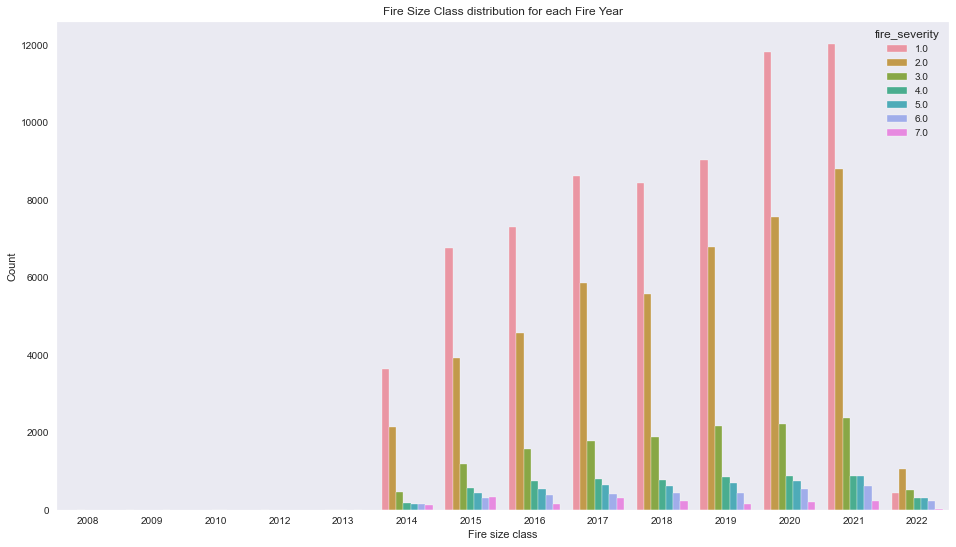

In [150]:
# plot fire size class 
plt.figure(figsize=(16,9), facecolor='white')
sns.set_style("dark")
sns.countplot(x ='YEAR', hue = "fire_severity", data = fires_daily_drop) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

In [151]:
fires_binary_encoded_ddrop = pd.get_dummies(fires_daily_drop, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_ddrop = fires_binary_encoded_ddrop.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_ddrop.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


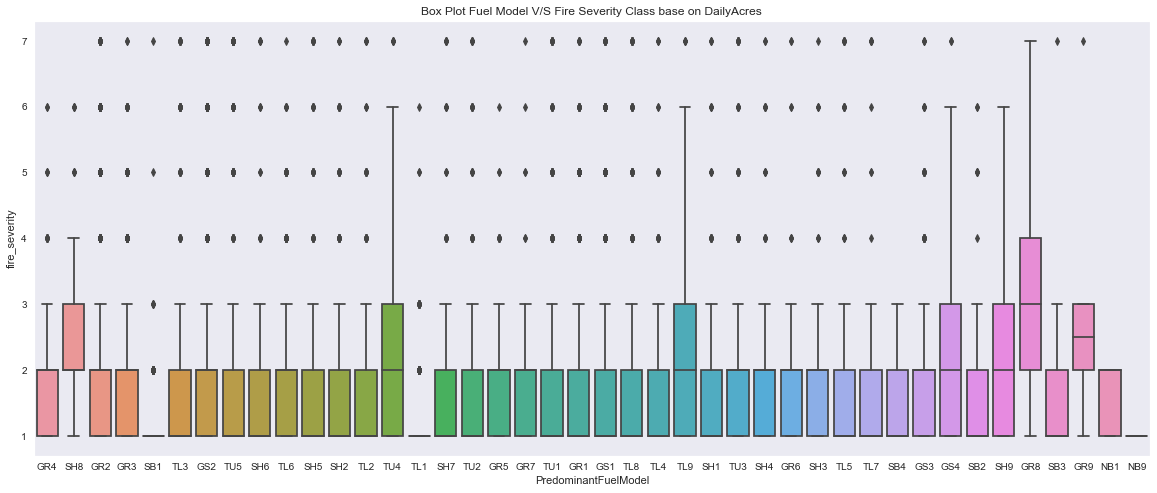

In [152]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='white')
sns.set_style("dark")
sns.boxplot(x='PredominantFuelModel',y='fire_severity', data=fires_daily_drop)
plt.title('Box Plot Fuel Model V/S Fire Severity Class base on DailyAcres')
plt.show()

In [153]:
# Define the features set.
X_ddrop = fires_binary_encoded_ddrop
X_ddrop = X_ddrop.drop(["fire_severity"], axis=1)
X_ddrop.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [154]:
# Define the target set.
y_ddrop = fires_binary_encoded_ddrop["fire_severity"].ravel()
y_ddrop[:5]

array([3., 3., 2., 4., 1.])

In [155]:
# Splitting into Train and Test sets.
X_ddrop_train, X_ddrop_test, y_ddrop_train, y_ddrop_test = train_test_split(X_ddrop, y_ddrop, random_state=78)

In [156]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_ddrop_scaler = scaler.fit(X_ddrop_train)

# Scaling the data.
X_ddrop_train_scaled = X_ddrop_scaler.transform(X_ddrop_train)
X_ddrop_test_scaled = X_ddrop_scaler.transform(X_ddrop_test)

In [157]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [158]:
# Fitting the model
rf_ddrop_model = rf_model.fit(X_ddrop_train_scaled, y_ddrop_train)

In [159]:
predictions_ddrop = rf_ddrop_model.predict(X_ddrop_test_scaled)

In [160]:
# Calculate feature importance in the Random Forest model.
importances_ddrop = rf_ddrop_model.feature_importances_
importances_ddrop

array([0.07439328, 0.03315504, 0.01083692, 0.00570927, 0.00761006,
       0.00327658, 0.00337129, 0.0056644 , 0.0030093 , 0.02608175,
       0.01925657, 0.007247  , 0.00508579, 0.00051812, 0.00041942,
       0.07531521, 0.01425974, 0.00671053, 0.00469052, 0.02049216,
       0.01614526, 0.00447866, 0.00485166, 0.02323077, 0.00636887,
       0.01434168, 0.00963067, 0.0038945 , 0.07041754, 0.01869966,
       0.06545307, 0.01989499, 0.0319447 , 0.01191994, 0.01063241,
       0.04842728, 0.01082448, 0.06162967, 0.0157314 , 0.00633483,
       0.0085135 , 0.04936462, 0.09761408, 0.03783841, 0.02471439])

In [161]:
# Features Sorted by Importance
sorted(zip(rf_ddrop_model.feature_importances_, X_ddrop.columns), reverse=True)

[(0.09761408260787924, 'FireCauseGeneral_1'),
 (0.07531521096217335, 'PredominantFuelModel_SB1'),
 (0.07439327929491078, 'PredominantFuelModel_GR1'),
 (0.07041753898106333, 'PredominantFuelModel_TL1'),
 (0.06545307212504715, 'PredominantFuelModel_TL3'),
 (0.06162967068093772, 'PredominantFuelModel_TU1'),
 (0.049364621036227, 'PredominantFuelModel_TU5'),
 (0.04842728094663762, 'PredominantFuelModel_TL8'),
 (0.03783841065771847, 'FireCauseGeneral_2'),
 (0.03315503661375342, 'PredominantFuelModel_GR2'),
 (0.03194470341708523, 'PredominantFuelModel_TL5'),
 (0.026081749711667154, 'PredominantFuelModel_GS1'),
 (0.024714394408618674, 'FireCauseGeneral_3'),
 (0.023230770589676552, 'PredominantFuelModel_SH5'),
 (0.02049216375333785, 'PredominantFuelModel_SH1'),
 (0.019894987397134373, 'PredominantFuelModel_TL4'),
 (0.019256571664384027, 'PredominantFuelModel_GS2'),
 (0.018699661640227003, 'PredominantFuelModel_TL2'),
 (0.01614526025149946, 'PredominantFuelModel_SH2'),
 (0.015731397186234966, 'P

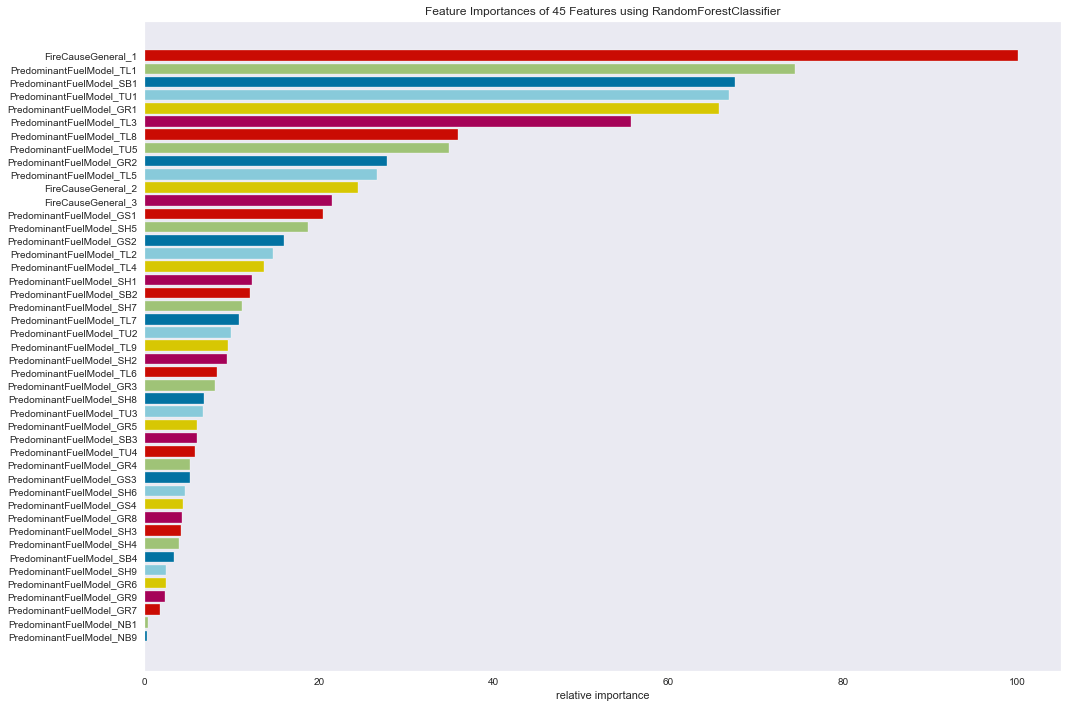

<AxesSubplot:title={'center':'Feature Importances of 45 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [162]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz_ddrop = FeatureImportances(model, size=(1080, 720))

viz_ddrop.fit(X_ddrop, y_ddrop)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz_ddrop.show()

In [163]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_ddrop = confusion_matrix(y_ddrop_test, predictions_ddrop)
# DataFrame from the confusion matrix.
cm_df_ddrop = pd.DataFrame(cm_ddrop, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_ddrop

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,15659,1231,14,0,0,0,1
Class 2,10128,1535,17,0,0,0,0
Class 3,2926,523,14,0,4,0,0
Class 4,1323,135,4,0,0,0,0
Class 5,1158,102,3,0,0,0,0
Class 6,842,63,0,0,1,0,0
Class 7,380,43,0,0,0,0,0


In [164]:
# Calculating the accuracy score.
acc_score_ddrop = accuracy_score(y_ddrop_test, predictions_ddrop)

In [165]:
# Displaying results
print("Confusion Matrix with dropna")
display(cm_df_ddrop)
print(f"Accuracy Score with dropna: {acc_score_ddrop}")
print("Classification Report with dropna")
print(classification_report(y_ddrop_test, predictions_ddrop))

Confusion Matrix with dropna


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,15659,1231,14,0,0,0,1
Class 2,10128,1535,17,0,0,0,0
Class 3,2926,523,14,0,4,0,0
Class 4,1323,135,4,0,0,0,0
Class 5,1158,102,3,0,0,0,0
Class 6,842,63,0,0,1,0,0
Class 7,380,43,0,0,0,0,0


Accuracy Score with dropna: 0.47659668753115825
Classification Report with dropna
              precision    recall  f1-score   support

         1.0       0.48      0.93      0.63     16905
         2.0       0.42      0.13      0.20     11680
         3.0       0.27      0.00      0.01      3467
         4.0       0.00      0.00      0.00      1462
         5.0       0.00      0.00      0.00      1263
         6.0       0.00      0.00      0.00       906
         7.0       0.00      0.00      0.00       423

    accuracy                           0.48     36106
   macro avg       0.17      0.15      0.12     36106
weighted avg       0.39      0.48      0.36     36106



In [166]:
from imblearn.combine import SMOTEENN

fires_smoteen_ddrop = fires_daily_drop.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DiscoveryAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_ddrop.head()

,DailyAcres,YEAR,fueltype_num,fire_severity
0,50.6,2020,3,3.0
2,50.0,2017,42,3.0
5,1.0,2020,26,2.0
6,170.0,2019,42,4.0
7,0.1,2020,1,1.0


In [167]:
x_ddrop_cols = [i for i in fires_smoteen_ddrop.columns if i not in ('fire_severity')]
X_ddrop = fires_smoteen_ddrop[x_ddrop_cols]
y_ddrop = fires_smoteen_ddrop['fire_severity']

In [168]:
X_ddrop_train, X_ddrop_test, y_ddrop_train, y_ddrop_test = train_test_split(X_ddrop, y_ddrop, random_state=1, stratify=y_ddrop)

In [169]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_ddrop_scaler = scaler.fit(X_ddrop_train)

# Scaling the data.
X_ddrop_train_scaled = X_ddrop_scaler.transform(X_ddrop_train)
X_ddrop_test_scaled = X_ddrop_scaler.transform(X_ddrop_test)

In [170]:
smoteenn = SMOTEENN(random_state=1)
X_ddrop_resampled, y_ddrop_resampled = smoteenn.fit_resample(X_ddrop_train_scaled, y_ddrop_train)
y_ddrop_resampled.value_counts()

7.0    51011
6.0    50995
5.0    50924
1.0    50912
4.0    50863
3.0    50840
2.0    50787
Name: fire_severity, dtype: int64

In [171]:
from sklearn.linear_model import LogisticRegression

smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_ddrop_resampled, y_ddrop_resampled)

LogisticRegression()

In [172]:
from sklearn.metrics import confusion_matrix

y_ddrop_pred = smoteen_model.predict(X_ddrop_test_scaled)
confusion_matrix(y_ddrop_test, y_ddrop_pred)

array([[11071,  5884,    49,     0,     0,     0,     0],
       [ 7090,  4122,   331,     0,     0,     0,     0],
       [ 1603,   191,  1514,   228,     0,     0,     0],
       [   17,     0,    12,  1448,     3,     0,     0],
       [    0,     0,     0,    52,  1173,    14,     0],
       [    0,     0,     0,     0,    18,   849,     6],
       [    0,     0,     0,     0,     0,     4,   427]])

In [173]:
from sklearn.metrics import balanced_accuracy_score

y_ddrop_pred = smoteen_model.predict(X_ddrop_test_scaled)
balanced_accuracy_score(y_ddrop_test, y_ddrop_pred)

0.7606695031203791

In [174]:
# Display the confusion matrix
smoteen_cm_ddrop = confusion_matrix(y_ddrop_test, y_ddrop_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df_ddrop = pd.DataFrame(cm_ddrop, index=["Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                                  columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
smoteen_cm_df_ddrop

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,15659,1231,14,0,0,0,1
Class 2,10128,1535,17,0,0,0,0
Class 3,2926,523,14,0,4,0,0
Class 4,1323,135,4,0,0,0,0
Class 5,1158,102,3,0,0,0,0
Class 6,842,63,0,0,1,0,0
Class 7,380,43,0,0,0,0,0


In [175]:
from imblearn.metrics import classification_report_imbalanced
print("Classification Report Imbalanced with dropna")
print(classification_report_imbalanced(y_ddrop_test, y_ddrop_pred))

Classification Report Imbalanced with dropna
                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.56      0.65      0.54      0.60      0.60      0.36     17004
        2.0       0.40      0.36      0.75      0.38      0.52      0.26     11543
        3.0       0.79      0.43      0.99      0.56      0.65      0.40      3536
        4.0       0.84      0.98      0.99      0.90      0.99      0.97      1480
        5.0       0.98      0.95      1.00      0.96      0.97      0.94      1239
        6.0       0.98      0.97      1.00      0.98      0.99      0.97       873
        7.0       0.99      0.99      1.00      0.99      1.00      0.99       431

avg / total       0.57      0.57      0.70      0.56      0.62      0.40     36106

